In [22]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()

In [23]:
weight_tuning=1
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            init.uniform_(self.weight, -bound,bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [24]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.relu(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.relu(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.relu(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.relu(activation)
        for i in range(self.number_of_layers):
             x=torch.relu(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.relu(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [25]:

#transform=
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [26]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)

# mean-squared error loss
criterion = nn.MSELoss()

#print(model.encoder_input_layer.weight)

cuda


In [27]:
import matplotlib.pyplot as plt 
epochs=3000
asymptotic_repetition=150


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,50
spectral_calculation=5
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3)
interval=50

In [28]:
def add_gaussian_noise(inputs,strength):
    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result
def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,average_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.zeros(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=temp
                print("infinity")
            temp=result
            diff+=result
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
            if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
                diff=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=2**-52
            distance.append(diff)
            continue
        distance.append(diff.cpu().detach().numpy()/no_of_image)

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



running


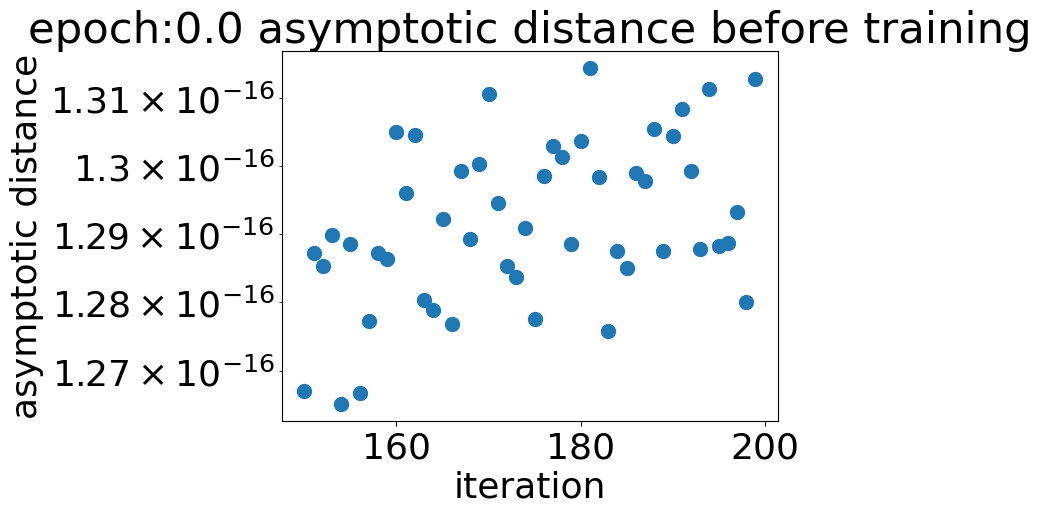

epoch : 1/3000, training loss = 0.198637,validation loss = 0.196227
epoch : 2/3000, training loss = 0.193124,validation loss = 0.189515
epoch : 3/3000, training loss = 0.184148,validation loss = 0.177492
epoch : 4/3000, training loss = 0.166892,validation loss = 0.152950
epoch : 5/3000, training loss = 0.133133,validation loss = 0.120244
epoch : 6/3000, training loss = 0.116670,validation loss = 0.114049
epoch : 7/3000, training loss = 0.113267,validation loss = 0.112318
epoch : 8/3000, training loss = 0.112048,validation loss = 0.111416
epoch : 9/3000, training loss = 0.111299,validation loss = 0.110792
epoch : 10/3000, training loss = 0.110719,validation loss = 0.110109
epoch : 11/3000, training loss = 0.110058,validation loss = 0.109653
epoch : 12/3000, training loss = 0.109722,validation loss = 0.109383
epoch : 13/3000, training loss = 0.109484,validation loss = 0.109173
epoch : 14/3000, training loss = 0.109294,validation loss = 0.109001
epoch : 15/3000, training loss = 0.109135,v

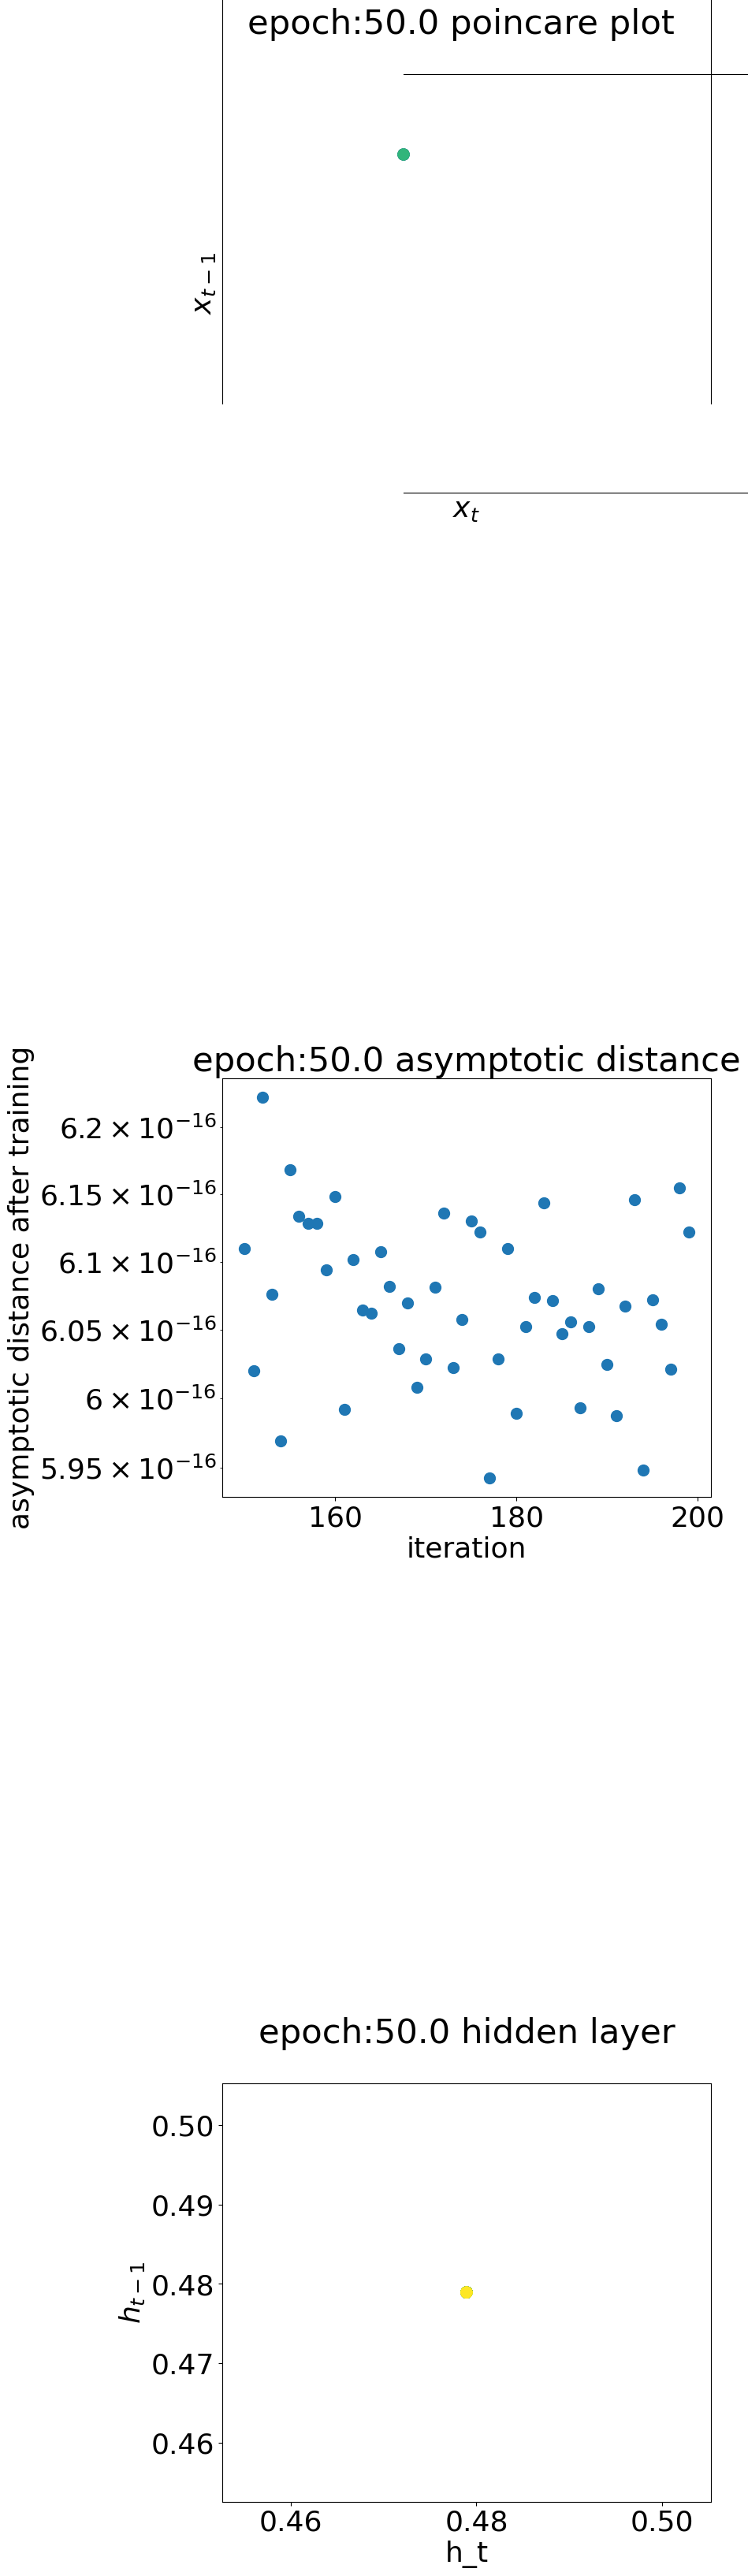

epoch : 51/3000, training loss = 0.103427,validation loss = 0.102967
epoch : 52/3000, training loss = 0.103006,validation loss = 0.102691
epoch : 53/3000, training loss = 0.102857,validation loss = 0.102566
epoch : 54/3000, training loss = 0.102727,validation loss = 0.102427
epoch : 55/3000, training loss = 0.102570,validation loss = 0.102102
epoch : 56/3000, training loss = 0.101949,validation loss = 0.101547
epoch : 57/3000, training loss = 0.101677,validation loss = 0.101324
epoch : 58/3000, training loss = 0.101260,validation loss = 0.100773
epoch : 59/3000, training loss = 0.100841,validation loss = 0.100419
epoch : 60/3000, training loss = 0.100439,validation loss = 0.099968
epoch : 61/3000, training loss = 0.099926,validation loss = 0.099385
epoch : 62/3000, training loss = 0.099185,validation loss = 0.098358
epoch : 63/3000, training loss = 0.097434,validation loss = 0.096468
epoch : 64/3000, training loss = 0.096102,validation loss = 0.095281
epoch : 65/3000, training loss = 0

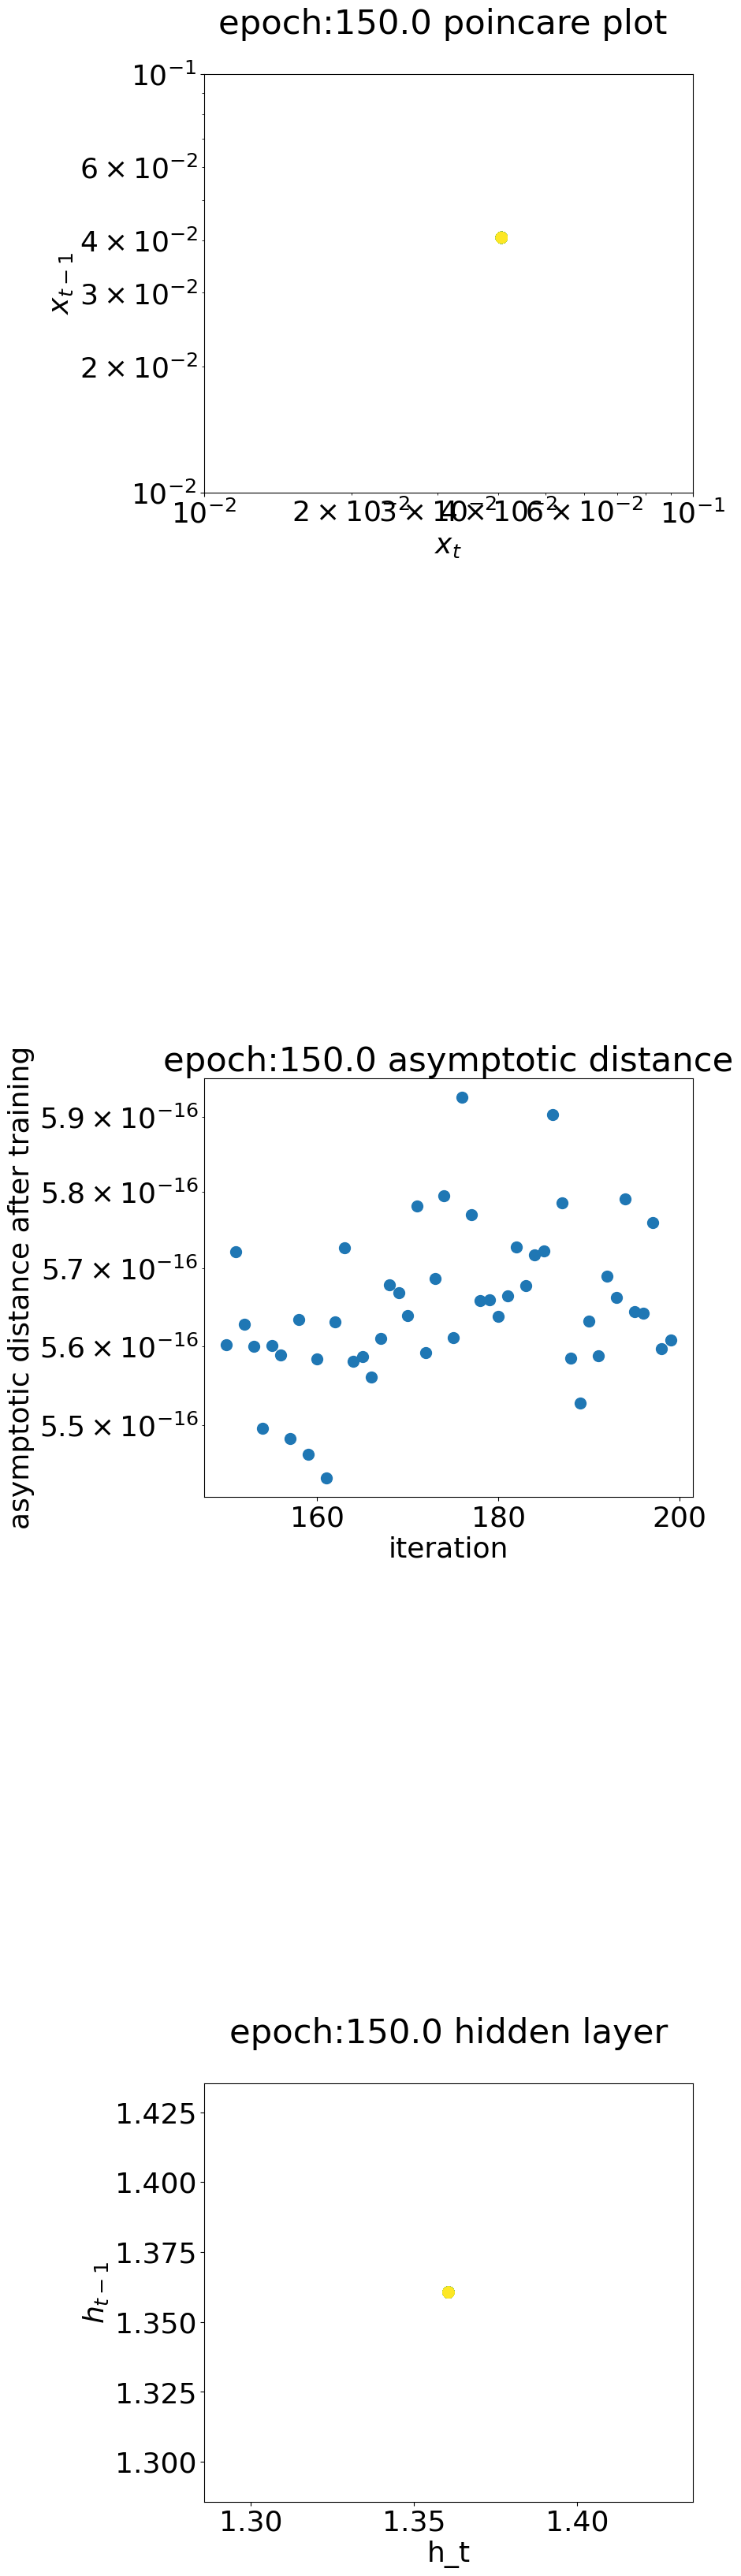

epoch : 151/3000, training loss = 0.069973,validation loss = 0.069815
epoch : 152/3000, training loss = 0.069922,validation loss = 0.069765
epoch : 153/3000, training loss = 0.069872,validation loss = 0.069716
epoch : 154/3000, training loss = 0.069822,validation loss = 0.069666
epoch : 155/3000, training loss = 0.069774,validation loss = 0.069618
epoch : 156/3000, training loss = 0.069726,validation loss = 0.069571
epoch : 157/3000, training loss = 0.069613,validation loss = 0.069303
epoch : 158/3000, training loss = 0.069292,validation loss = 0.069033
epoch : 159/3000, training loss = 0.069089,validation loss = 0.068866
epoch : 160/3000, training loss = 0.068958,validation loss = 0.068786
epoch : 161/3000, training loss = 0.068699,validation loss = 0.068498
epoch : 162/3000, training loss = 0.068603,validation loss = 0.068435
epoch : 163/3000, training loss = 0.068546,validation loss = 0.068382
epoch : 164/3000, training loss = 0.068495,validation loss = 0.068334
epoch : 165/3000, tr

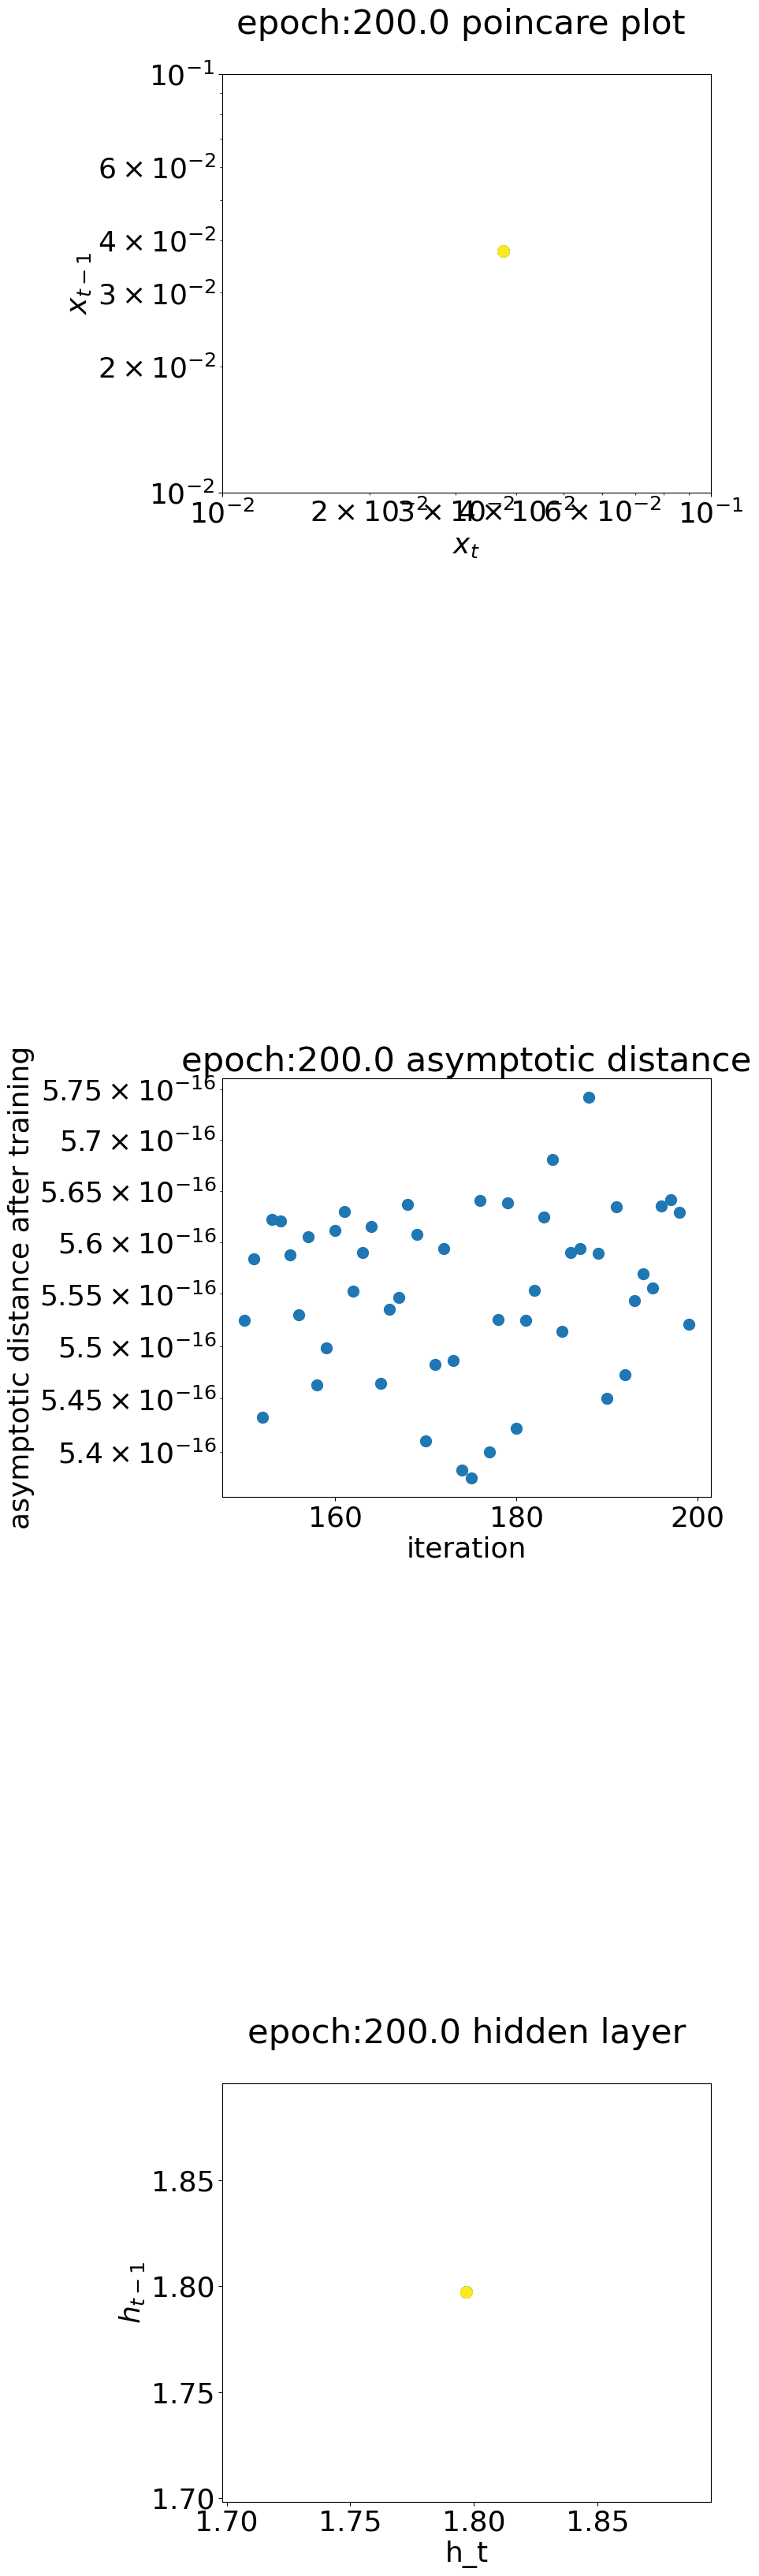

epoch : 201/3000, training loss = 0.067070,validation loss = 0.066911
epoch : 202/3000, training loss = 0.067024,validation loss = 0.066864
epoch : 203/3000, training loss = 0.066976,validation loss = 0.066816
epoch : 204/3000, training loss = 0.066926,validation loss = 0.066766
epoch : 205/3000, training loss = 0.066875,validation loss = 0.066714
epoch : 206/3000, training loss = 0.066822,validation loss = 0.066660
epoch : 207/3000, training loss = 0.066767,validation loss = 0.066605
epoch : 208/3000, training loss = 0.066710,validation loss = 0.066547
epoch : 209/3000, training loss = 0.066651,validation loss = 0.066488
epoch : 210/3000, training loss = 0.066590,validation loss = 0.066427
epoch : 211/3000, training loss = 0.066528,validation loss = 0.066365
epoch : 212/3000, training loss = 0.066464,validation loss = 0.066301
epoch : 213/3000, training loss = 0.066398,validation loss = 0.066235
epoch : 214/3000, training loss = 0.066332,validation loss = 0.066168
epoch : 215/3000, tr

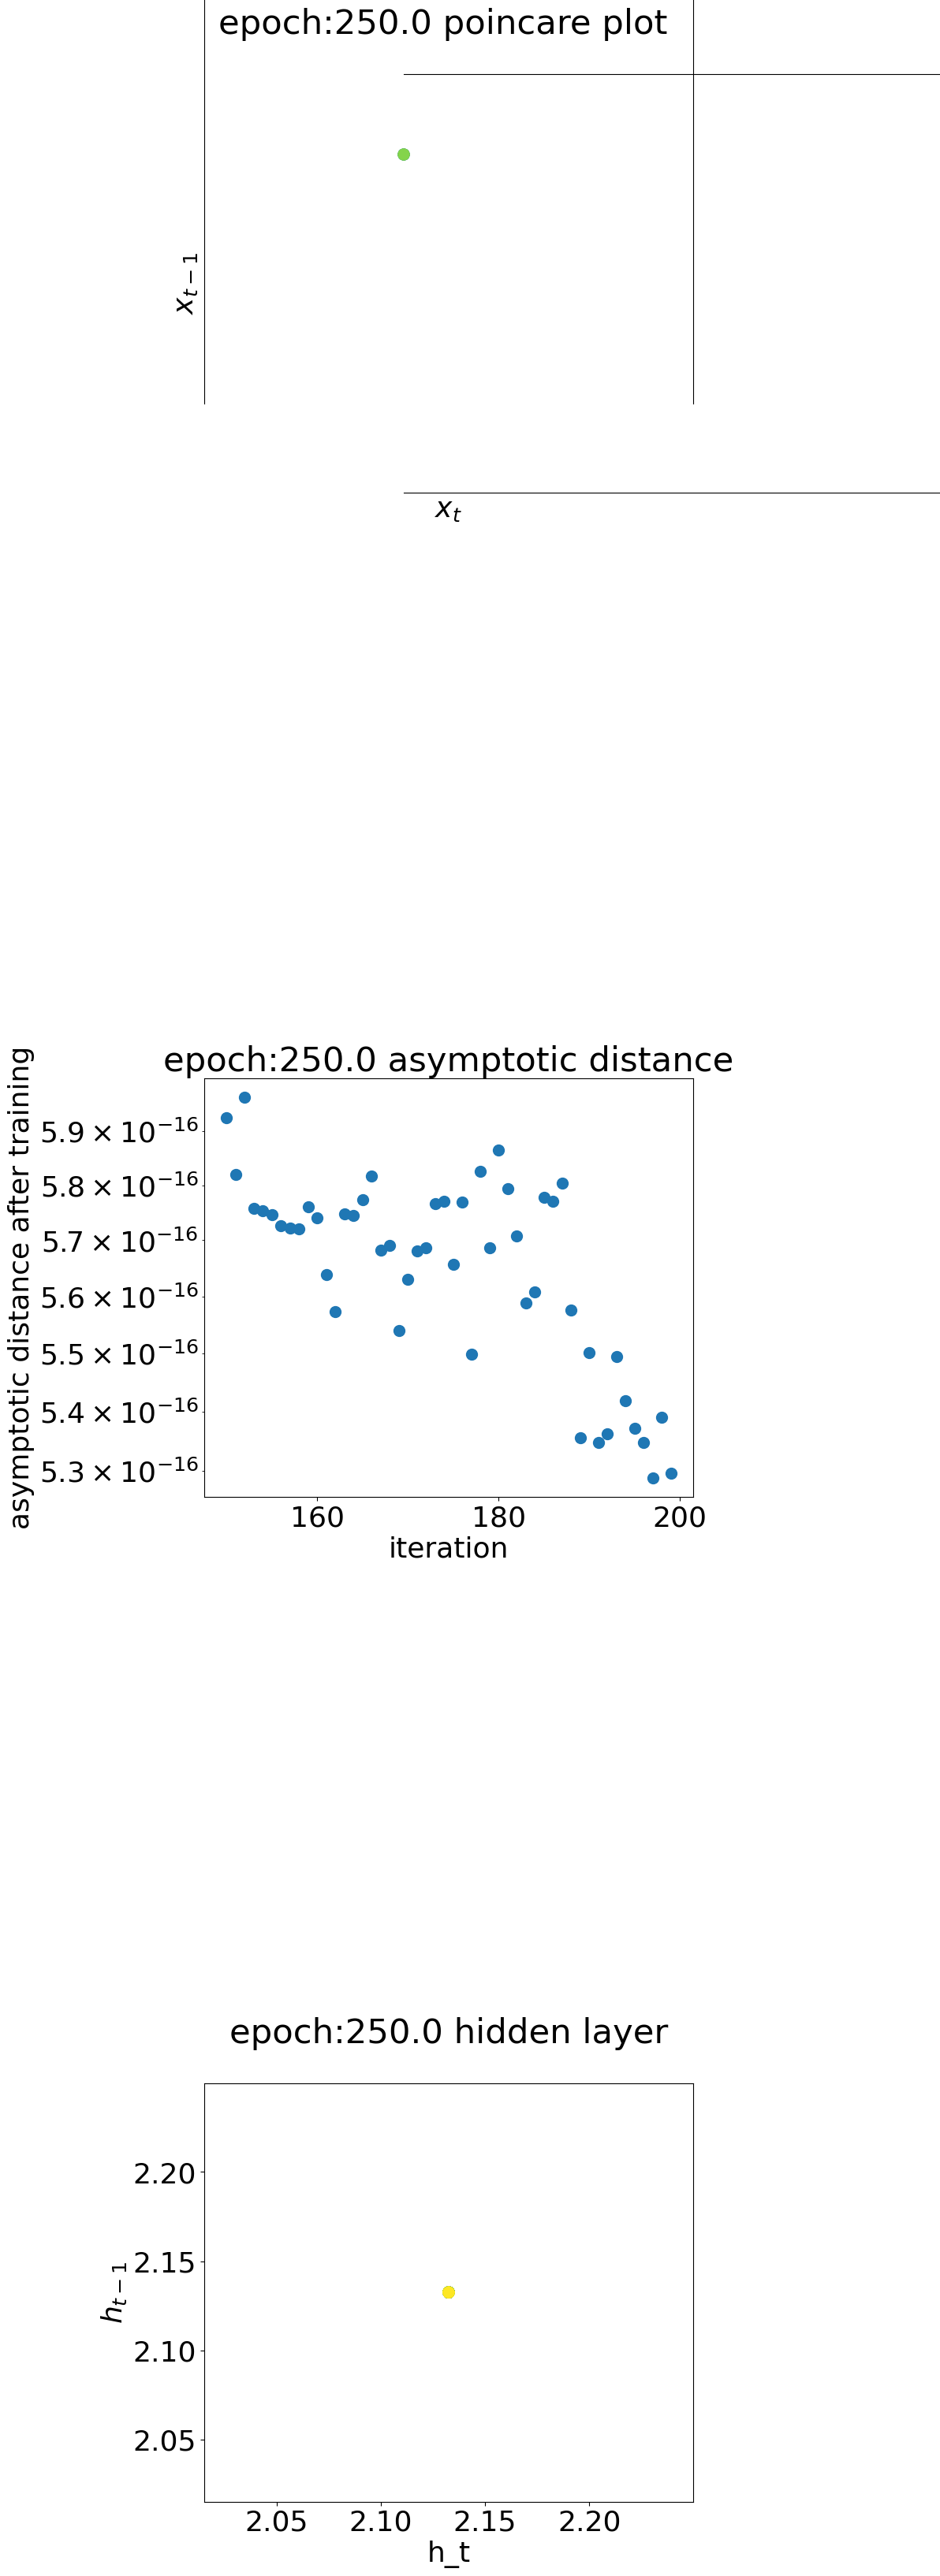

epoch : 251/3000, training loss = 0.063992,validation loss = 0.063864
epoch : 252/3000, training loss = 0.063962,validation loss = 0.063835
epoch : 253/3000, training loss = 0.063933,validation loss = 0.063807
epoch : 254/3000, training loss = 0.063905,validation loss = 0.063780
epoch : 255/3000, training loss = 0.063878,validation loss = 0.063753
epoch : 256/3000, training loss = 0.063851,validation loss = 0.063728
epoch : 257/3000, training loss = 0.063825,validation loss = 0.063702
epoch : 258/3000, training loss = 0.063799,validation loss = 0.063677
epoch : 259/3000, training loss = 0.063774,validation loss = 0.063653
epoch : 260/3000, training loss = 0.063750,validation loss = 0.063630
epoch : 261/3000, training loss = 0.063726,validation loss = 0.063606
epoch : 262/3000, training loss = 0.063699,validation loss = 0.063575
epoch : 263/3000, training loss = 0.063670,validation loss = 0.063551
epoch : 264/3000, training loss = 0.063645,validation loss = 0.063527
epoch : 265/3000, tr

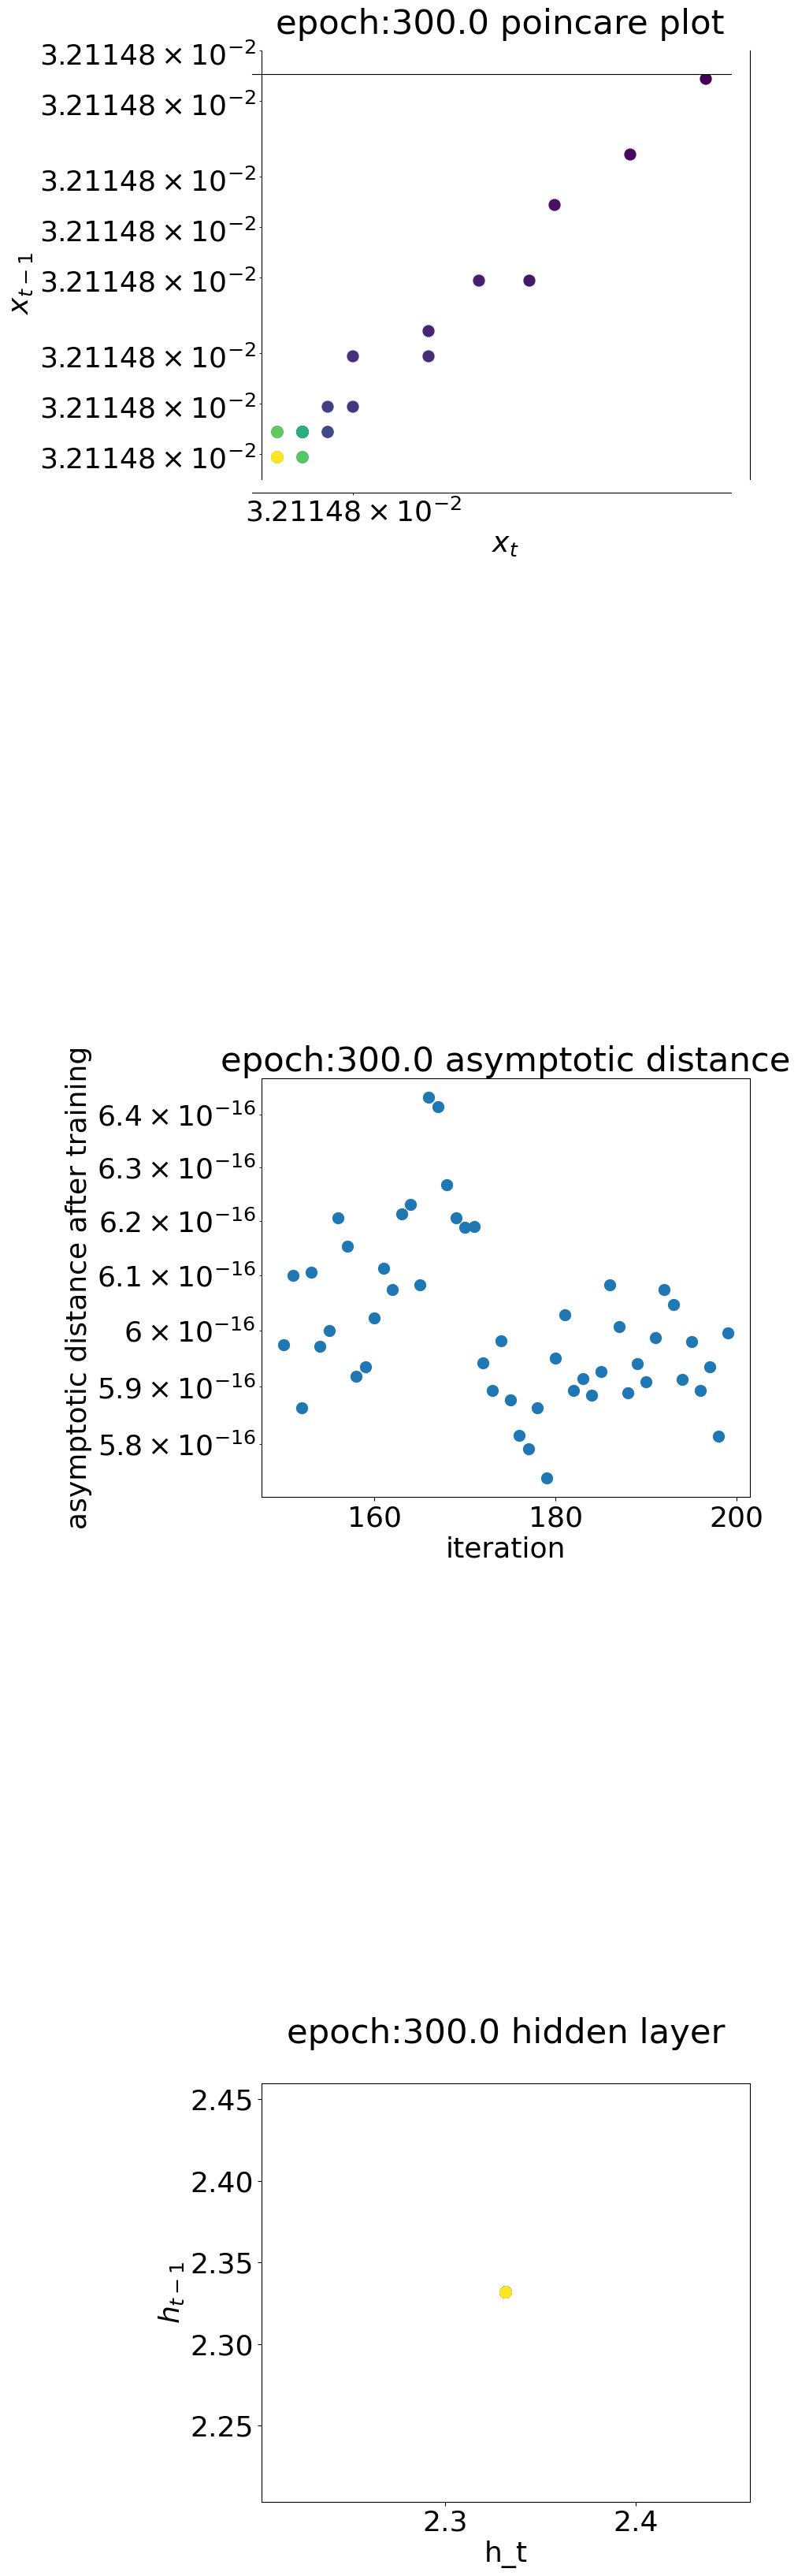

epoch : 301/3000, training loss = 0.062526,validation loss = 0.062423
epoch : 302/3000, training loss = 0.062505,validation loss = 0.062403
epoch : 303/3000, training loss = 0.062485,validation loss = 0.062383
epoch : 304/3000, training loss = 0.062465,validation loss = 0.062363
epoch : 305/3000, training loss = 0.062444,validation loss = 0.062343
epoch : 306/3000, training loss = 0.062423,validation loss = 0.062323
epoch : 307/3000, training loss = 0.062402,validation loss = 0.062302
epoch : 308/3000, training loss = 0.062381,validation loss = 0.062281
epoch : 309/3000, training loss = 0.062359,validation loss = 0.062260
epoch : 310/3000, training loss = 0.062337,validation loss = 0.062239
epoch : 311/3000, training loss = 0.062315,validation loss = 0.062217
epoch : 312/3000, training loss = 0.062292,validation loss = 0.062195
epoch : 313/3000, training loss = 0.062269,validation loss = 0.062172
epoch : 314/3000, training loss = 0.062246,validation loss = 0.062150
epoch : 315/3000, tr

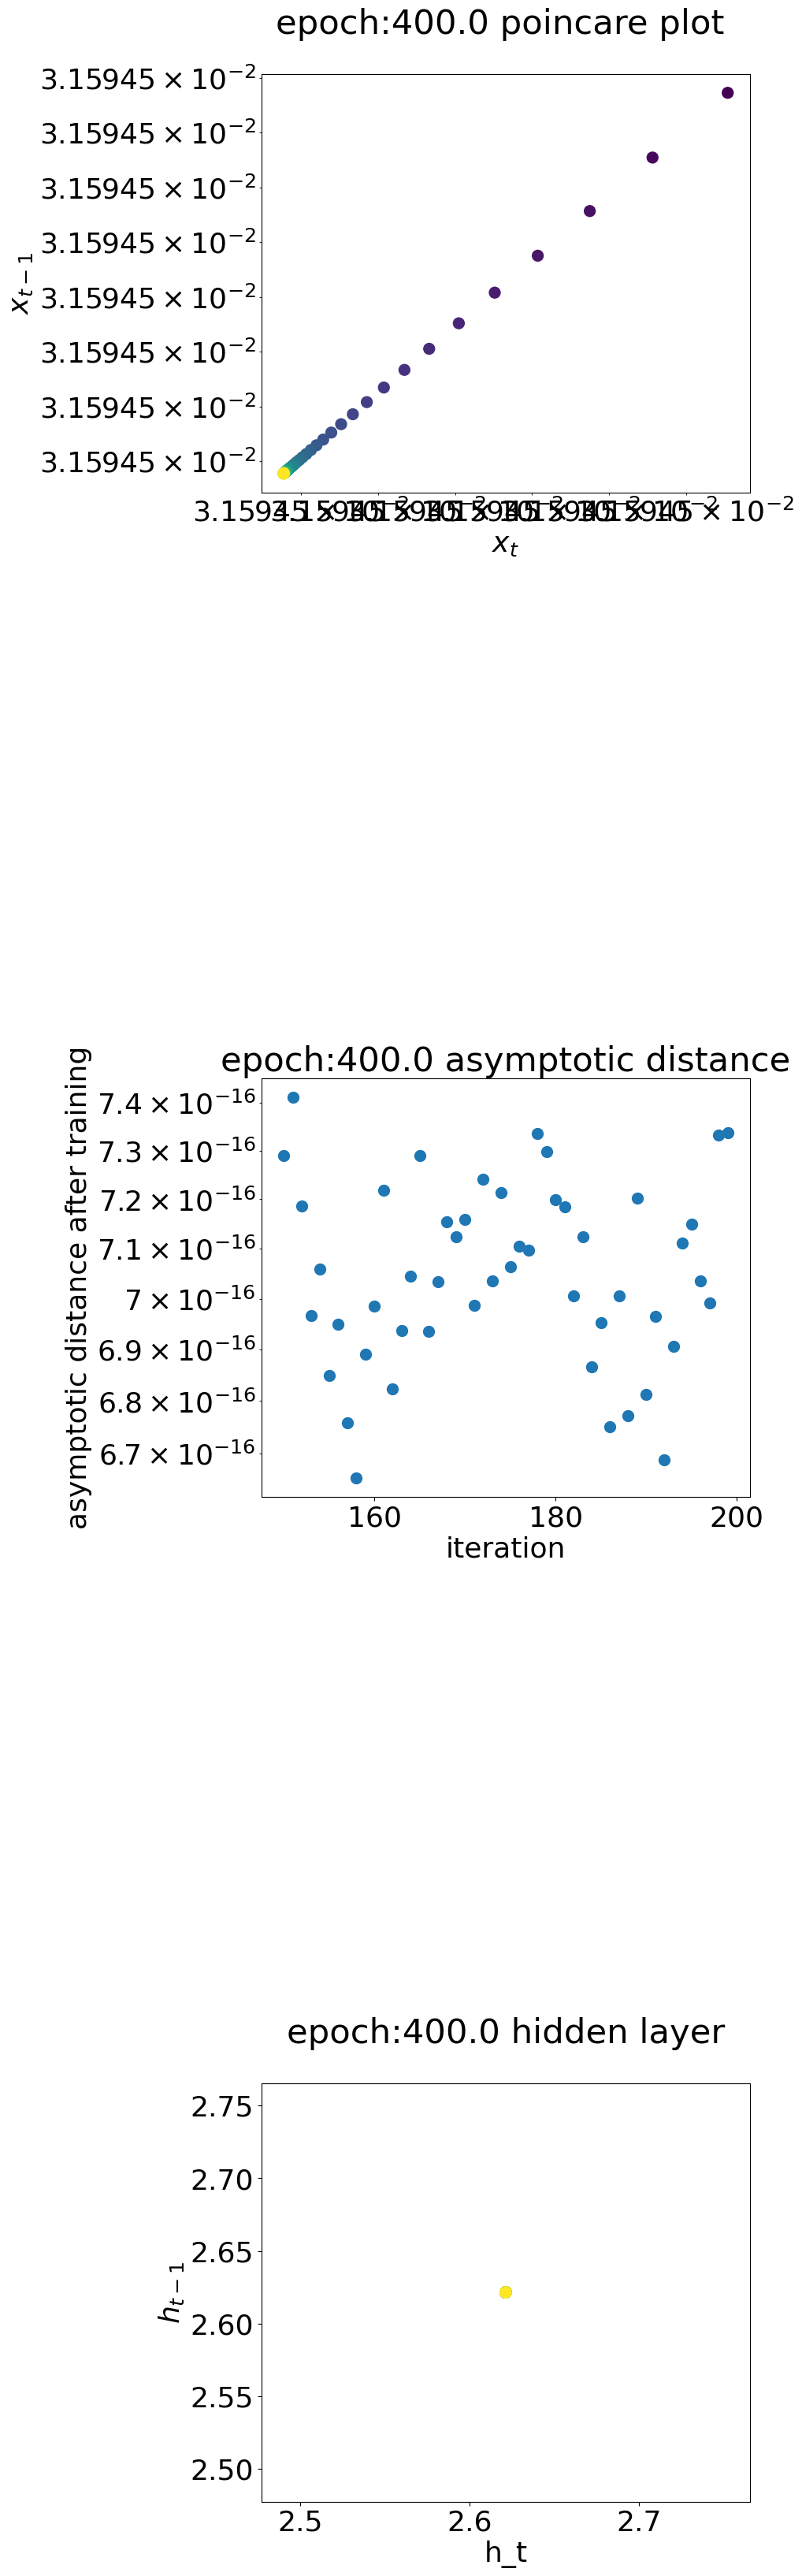

epoch : 401/3000, training loss = 0.058090,validation loss = 0.058087
epoch : 402/3000, training loss = 0.058062,validation loss = 0.058061
epoch : 403/3000, training loss = 0.058035,validation loss = 0.058034
epoch : 404/3000, training loss = 0.058008,validation loss = 0.058008
epoch : 405/3000, training loss = 0.057981,validation loss = 0.057982
epoch : 406/3000, training loss = 0.057955,validation loss = 0.057957
epoch : 407/3000, training loss = 0.057929,validation loss = 0.057932
epoch : 408/3000, training loss = 0.057903,validation loss = 0.057907
epoch : 409/3000, training loss = 0.057878,validation loss = 0.057882
epoch : 410/3000, training loss = 0.057853,validation loss = 0.057858
epoch : 411/3000, training loss = 0.057828,validation loss = 0.057835
epoch : 412/3000, training loss = 0.057804,validation loss = 0.057811
epoch : 413/3000, training loss = 0.057780,validation loss = 0.057788
epoch : 414/3000, training loss = 0.057756,validation loss = 0.057765
epoch : 415/3000, tr

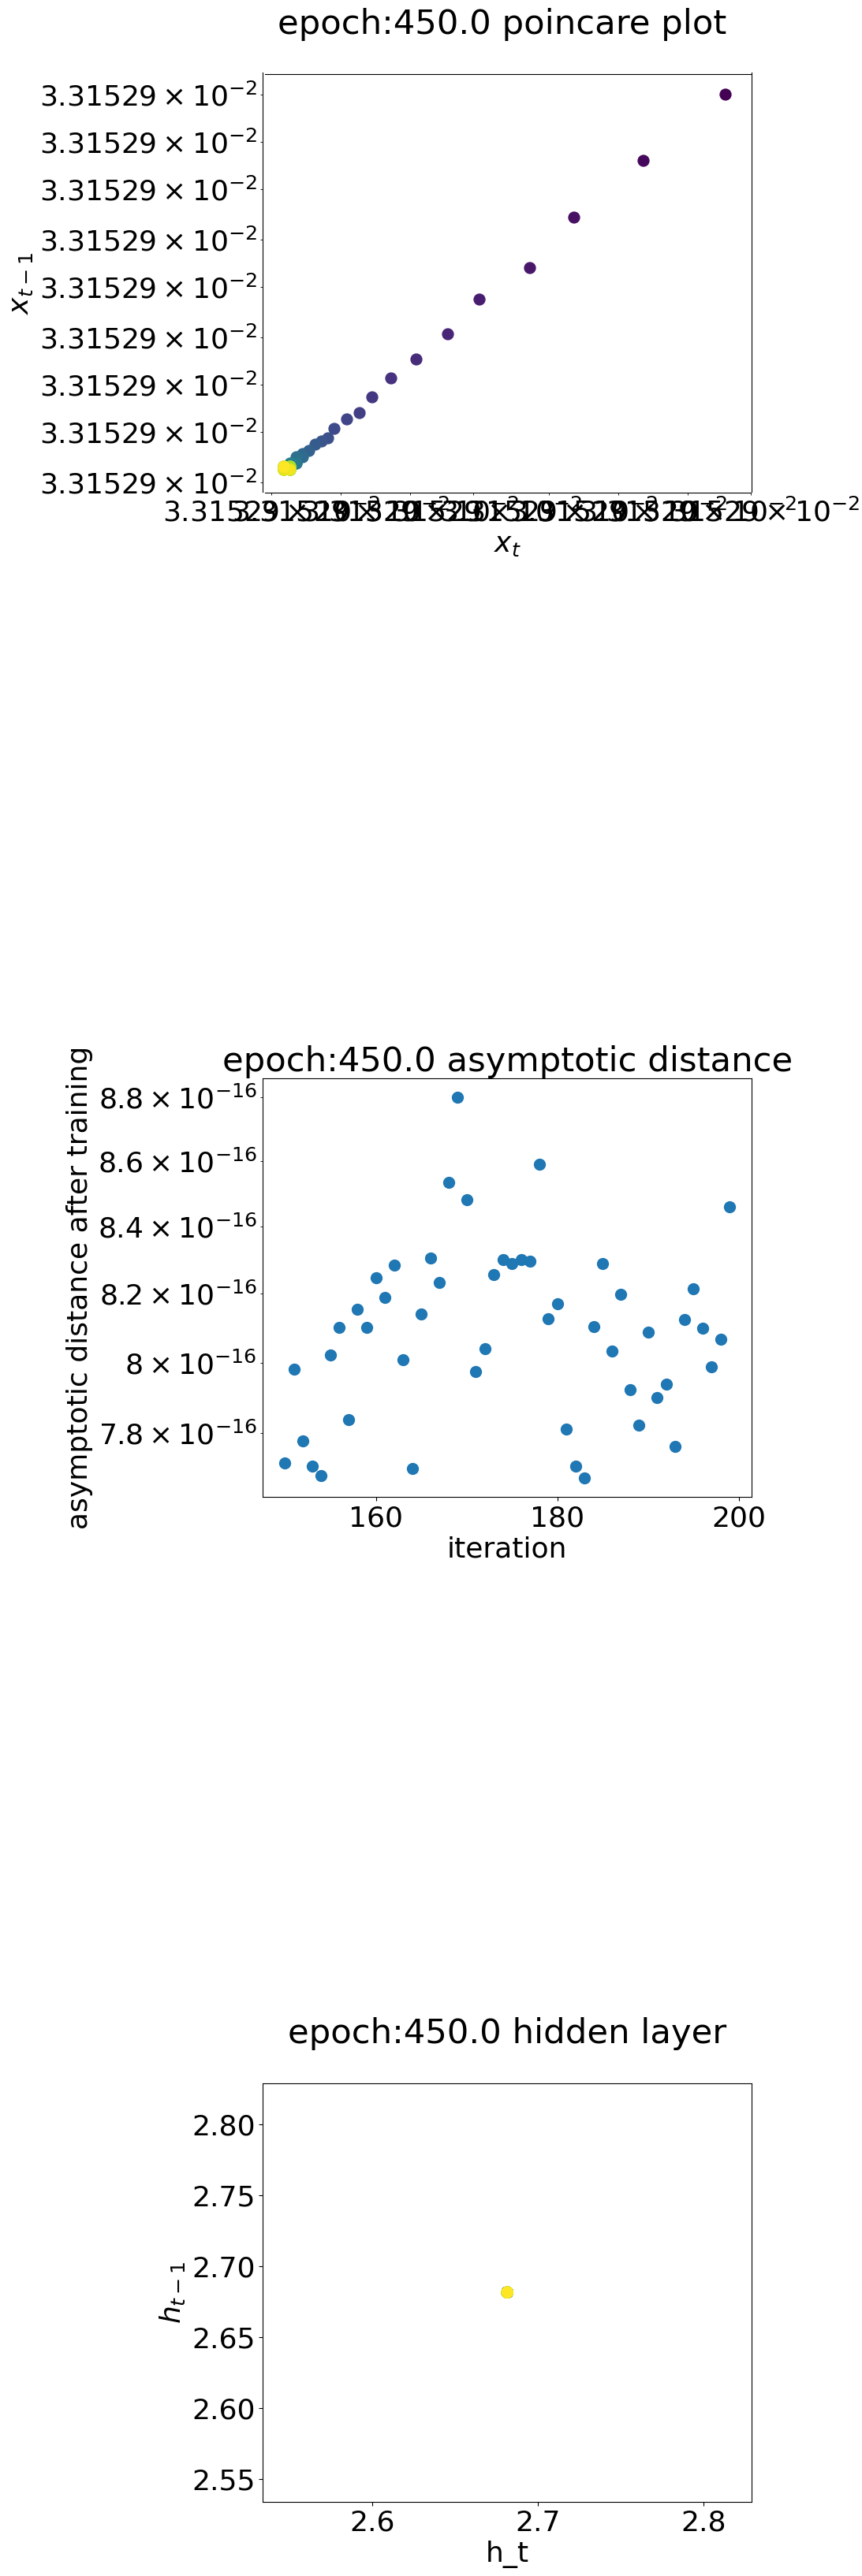

epoch : 451/3000, training loss = 0.056329,validation loss = 0.056360
epoch : 452/3000, training loss = 0.056313,validation loss = 0.056345
epoch : 453/3000, training loss = 0.056297,validation loss = 0.056329
epoch : 454/3000, training loss = 0.056281,validation loss = 0.056314
epoch : 455/3000, training loss = 0.056266,validation loss = 0.056299
epoch : 456/3000, training loss = 0.056250,validation loss = 0.056284
epoch : 457/3000, training loss = 0.056234,validation loss = 0.056269
epoch : 458/3000, training loss = 0.056219,validation loss = 0.056254
epoch : 459/3000, training loss = 0.056203,validation loss = 0.056239
epoch : 460/3000, training loss = 0.056188,validation loss = 0.056224
epoch : 461/3000, training loss = 0.056173,validation loss = 0.056209
epoch : 462/3000, training loss = 0.056157,validation loss = 0.056195
epoch : 463/3000, training loss = 0.056142,validation loss = 0.056180
epoch : 464/3000, training loss = 0.056127,validation loss = 0.056166
epoch : 465/3000, tr

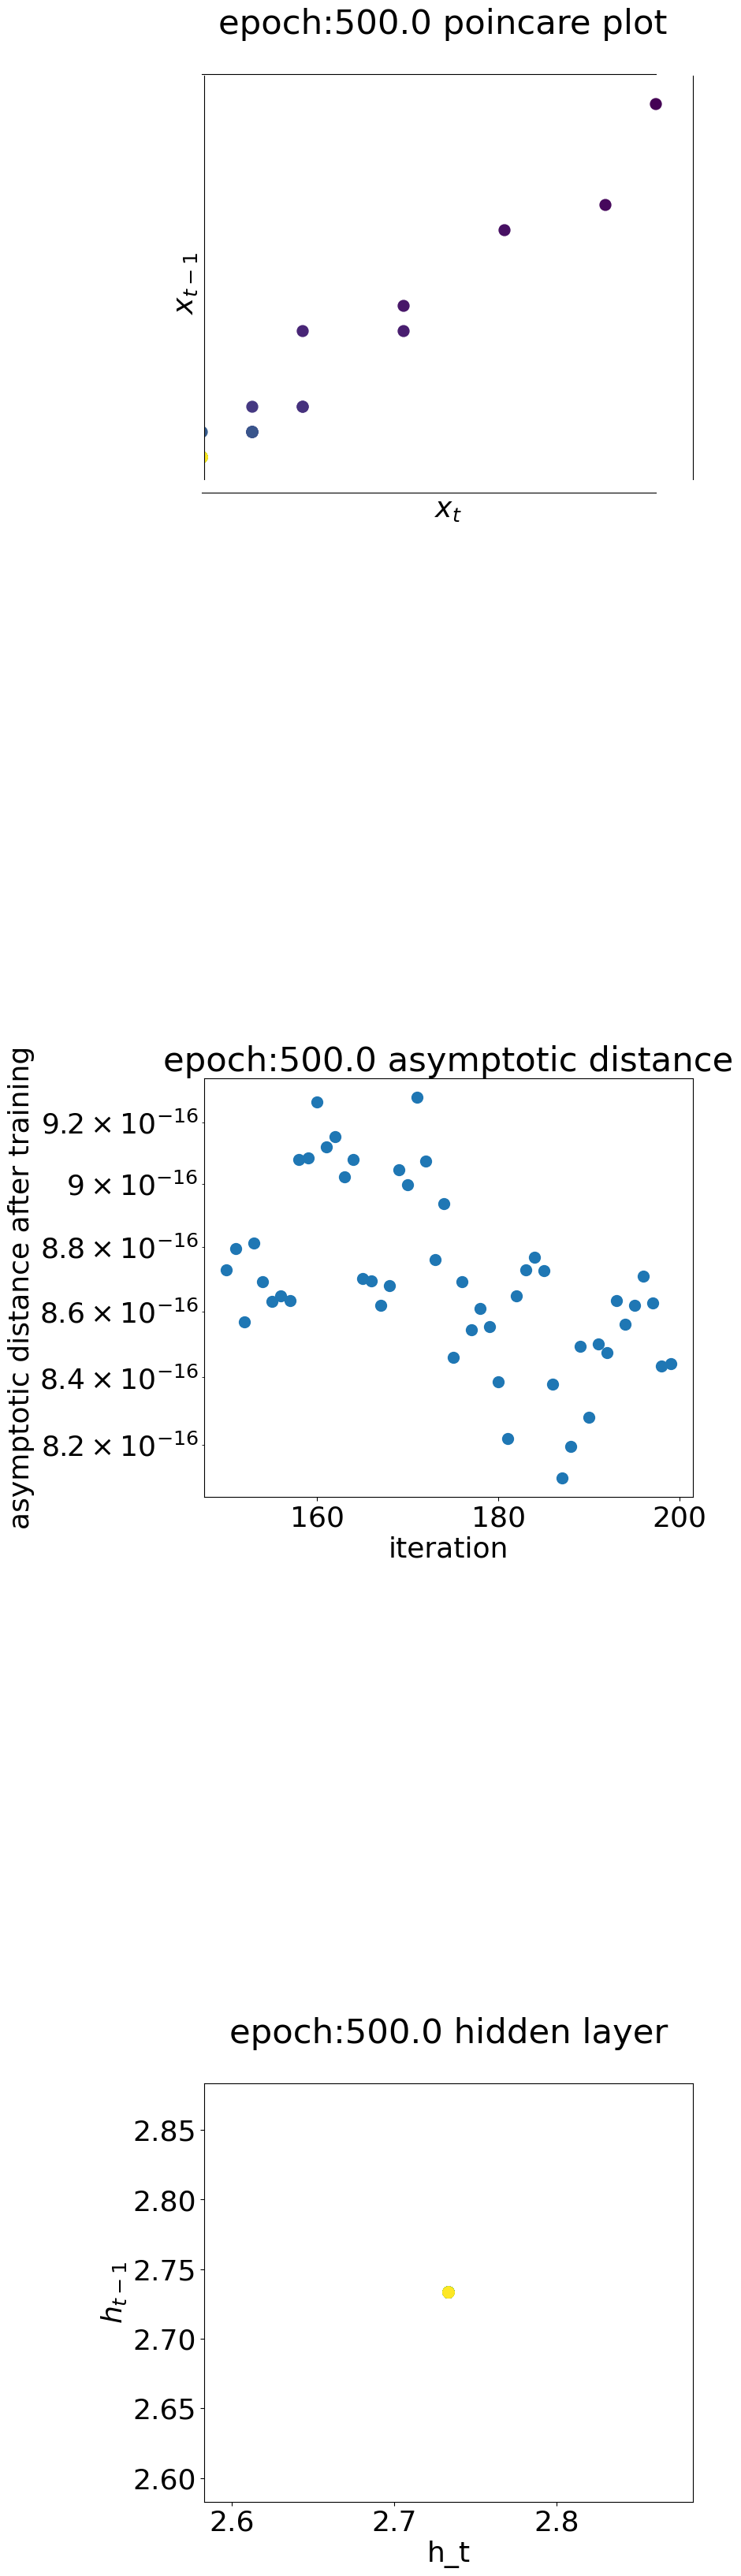

epoch : 501/3000, training loss = 0.055598,validation loss = 0.055656
epoch : 502/3000, training loss = 0.055584,validation loss = 0.055642
epoch : 503/3000, training loss = 0.055570,validation loss = 0.055628
epoch : 504/3000, training loss = 0.055556,validation loss = 0.055615
epoch : 505/3000, training loss = 0.055542,validation loss = 0.055601
epoch : 506/3000, training loss = 0.055528,validation loss = 0.055588
epoch : 507/3000, training loss = 0.055513,validation loss = 0.055574
epoch : 508/3000, training loss = 0.055499,validation loss = 0.055560
epoch : 509/3000, training loss = 0.055485,validation loss = 0.055546
epoch : 510/3000, training loss = 0.055471,validation loss = 0.055532
epoch : 511/3000, training loss = 0.055457,validation loss = 0.055519
epoch : 512/3000, training loss = 0.055443,validation loss = 0.055505
epoch : 513/3000, training loss = 0.055429,validation loss = 0.055491
epoch : 514/3000, training loss = 0.055414,validation loss = 0.055477
epoch : 515/3000, tr

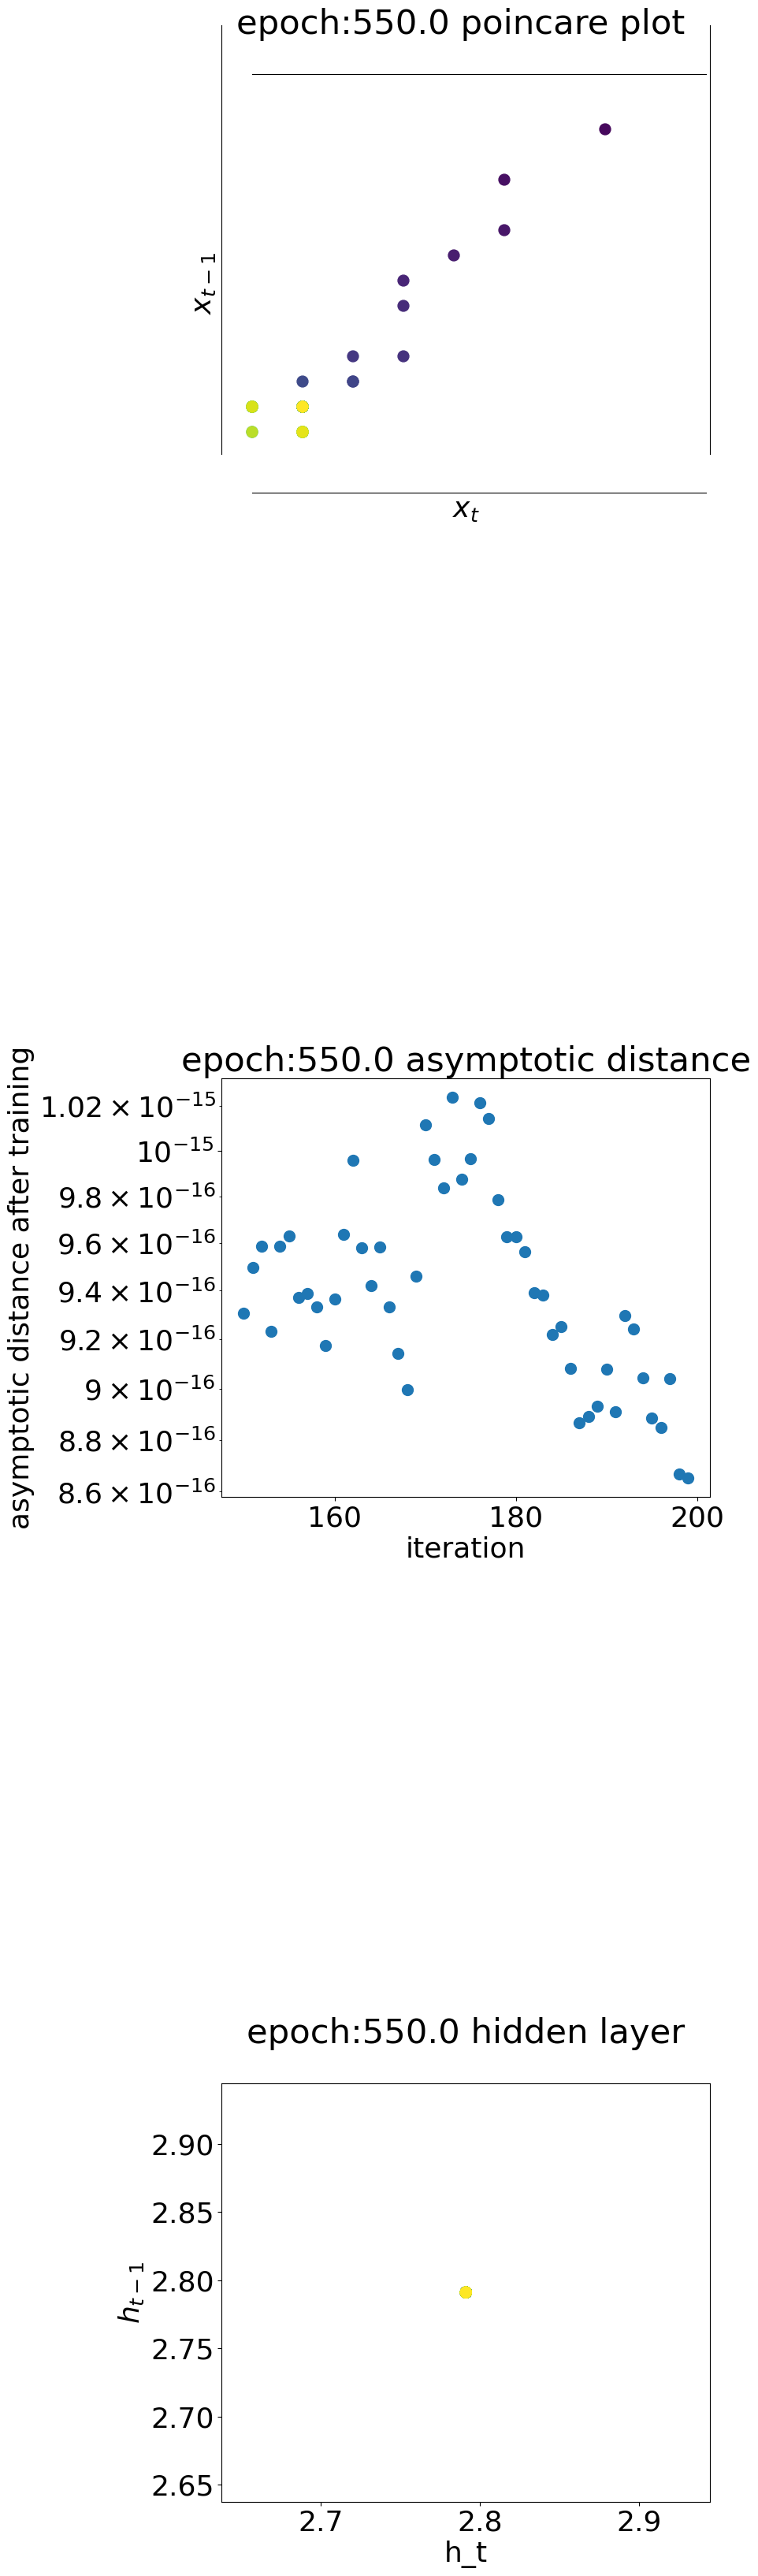

epoch : 551/3000, training loss = 0.054915,validation loss = 0.054991
epoch : 552/3000, training loss = 0.054904,validation loss = 0.054980
epoch : 553/3000, training loss = 0.054892,validation loss = 0.054969
epoch : 554/3000, training loss = 0.054881,validation loss = 0.054957
epoch : 555/3000, training loss = 0.054870,validation loss = 0.054947
epoch : 556/3000, training loss = 0.054859,validation loss = 0.054936
epoch : 557/3000, training loss = 0.054848,validation loss = 0.054925
epoch : 558/3000, training loss = 0.054837,validation loss = 0.054915
epoch : 559/3000, training loss = 0.054826,validation loss = 0.054905
epoch : 560/3000, training loss = 0.054816,validation loss = 0.054894
epoch : 561/3000, training loss = 0.054805,validation loss = 0.054884
epoch : 562/3000, training loss = 0.054795,validation loss = 0.054874
epoch : 563/3000, training loss = 0.054784,validation loss = 0.054863
epoch : 564/3000, training loss = 0.054774,validation loss = 0.054853
epoch : 565/3000, tr

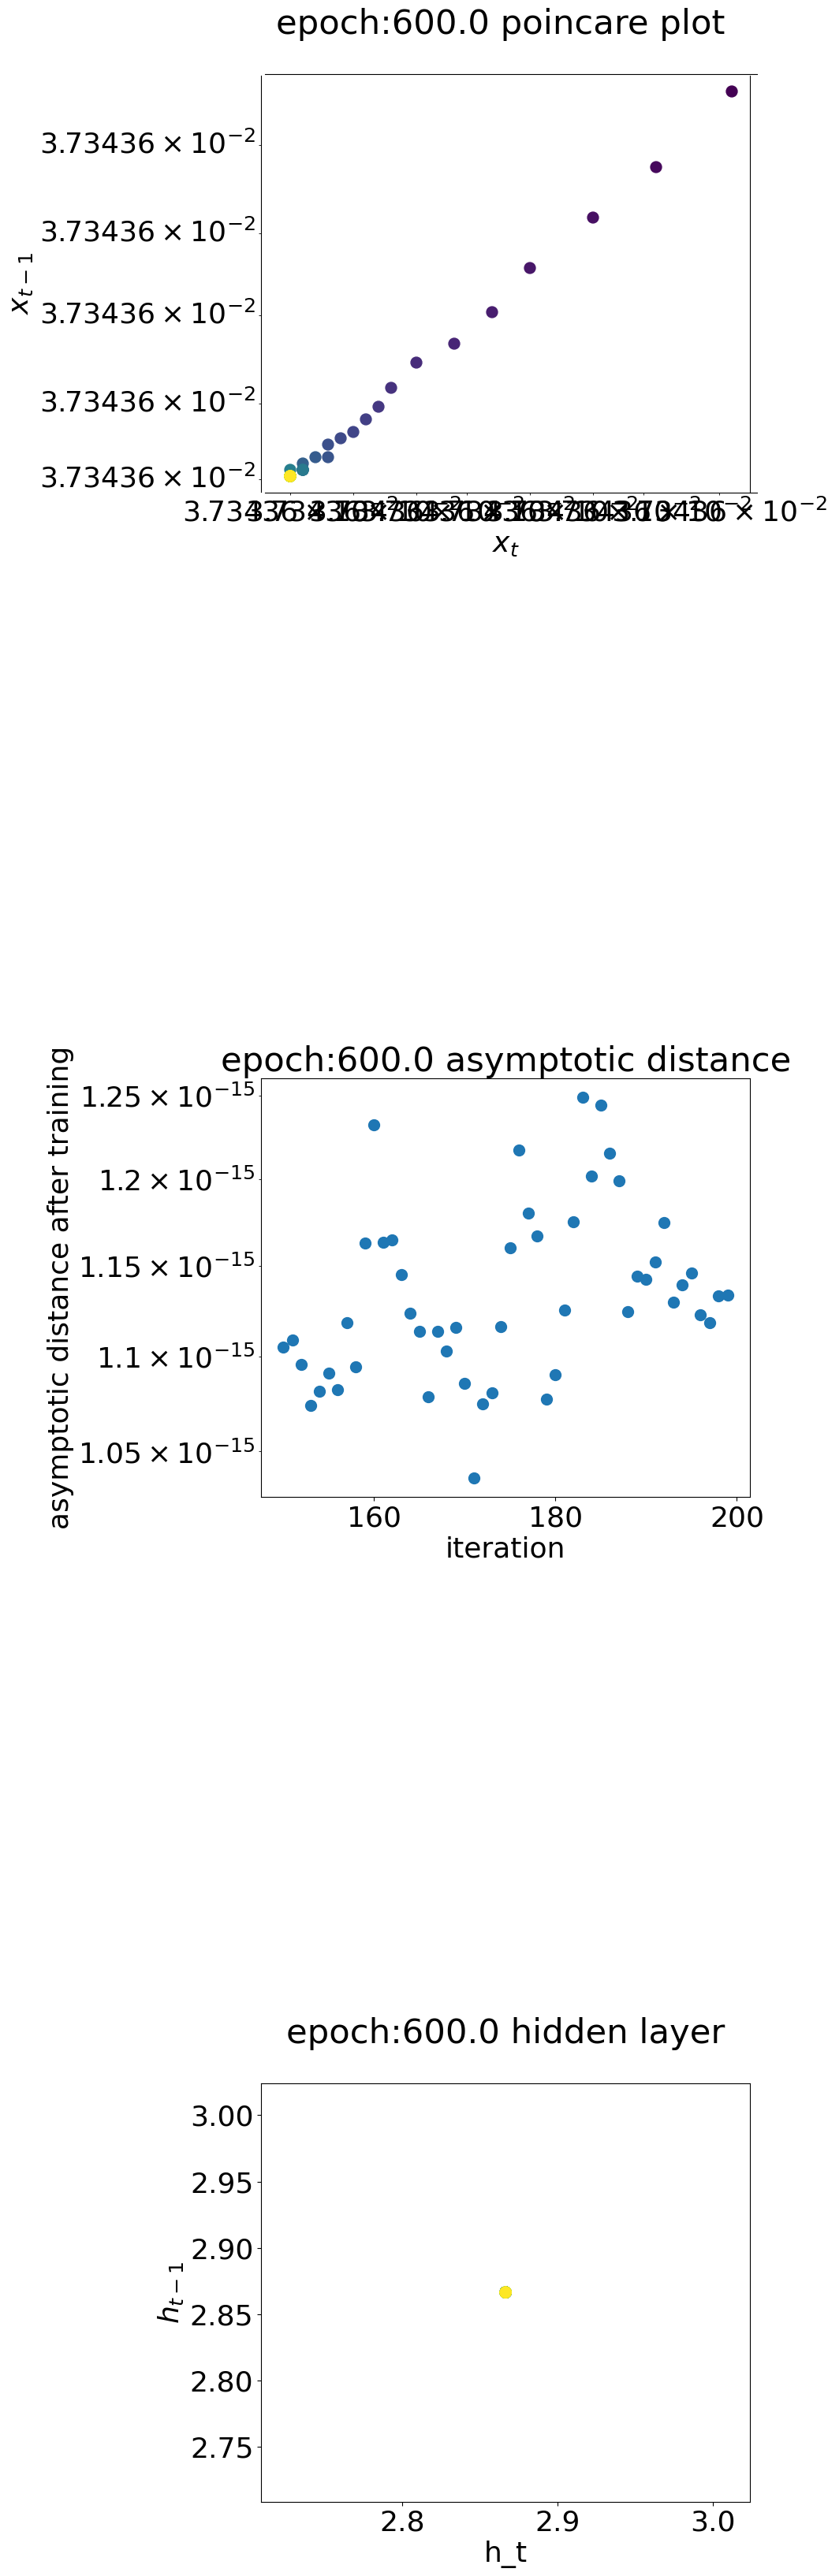

epoch : 601/3000, training loss = 0.054403,validation loss = 0.054487
epoch : 602/3000, training loss = 0.054391,validation loss = 0.054474
epoch : 603/3000, training loss = 0.054335,validation loss = 0.054301
epoch : 604/3000, training loss = 0.054190,validation loss = 0.054258
epoch : 605/3000, training loss = 0.054163,validation loss = 0.054239
epoch : 606/3000, training loss = 0.054145,validation loss = 0.054223
epoch : 607/3000, training loss = 0.054131,validation loss = 0.054209
epoch : 608/3000, training loss = 0.054118,validation loss = 0.054198
epoch : 609/3000, training loss = 0.054107,validation loss = 0.054187
epoch : 610/3000, training loss = 0.054096,validation loss = 0.054177
epoch : 611/3000, training loss = 0.054087,validation loss = 0.054168
epoch : 612/3000, training loss = 0.054077,validation loss = 0.054159
epoch : 613/3000, training loss = 0.054068,validation loss = 0.054150
epoch : 614/3000, training loss = 0.054059,validation loss = 0.054141
epoch : 615/3000, tr

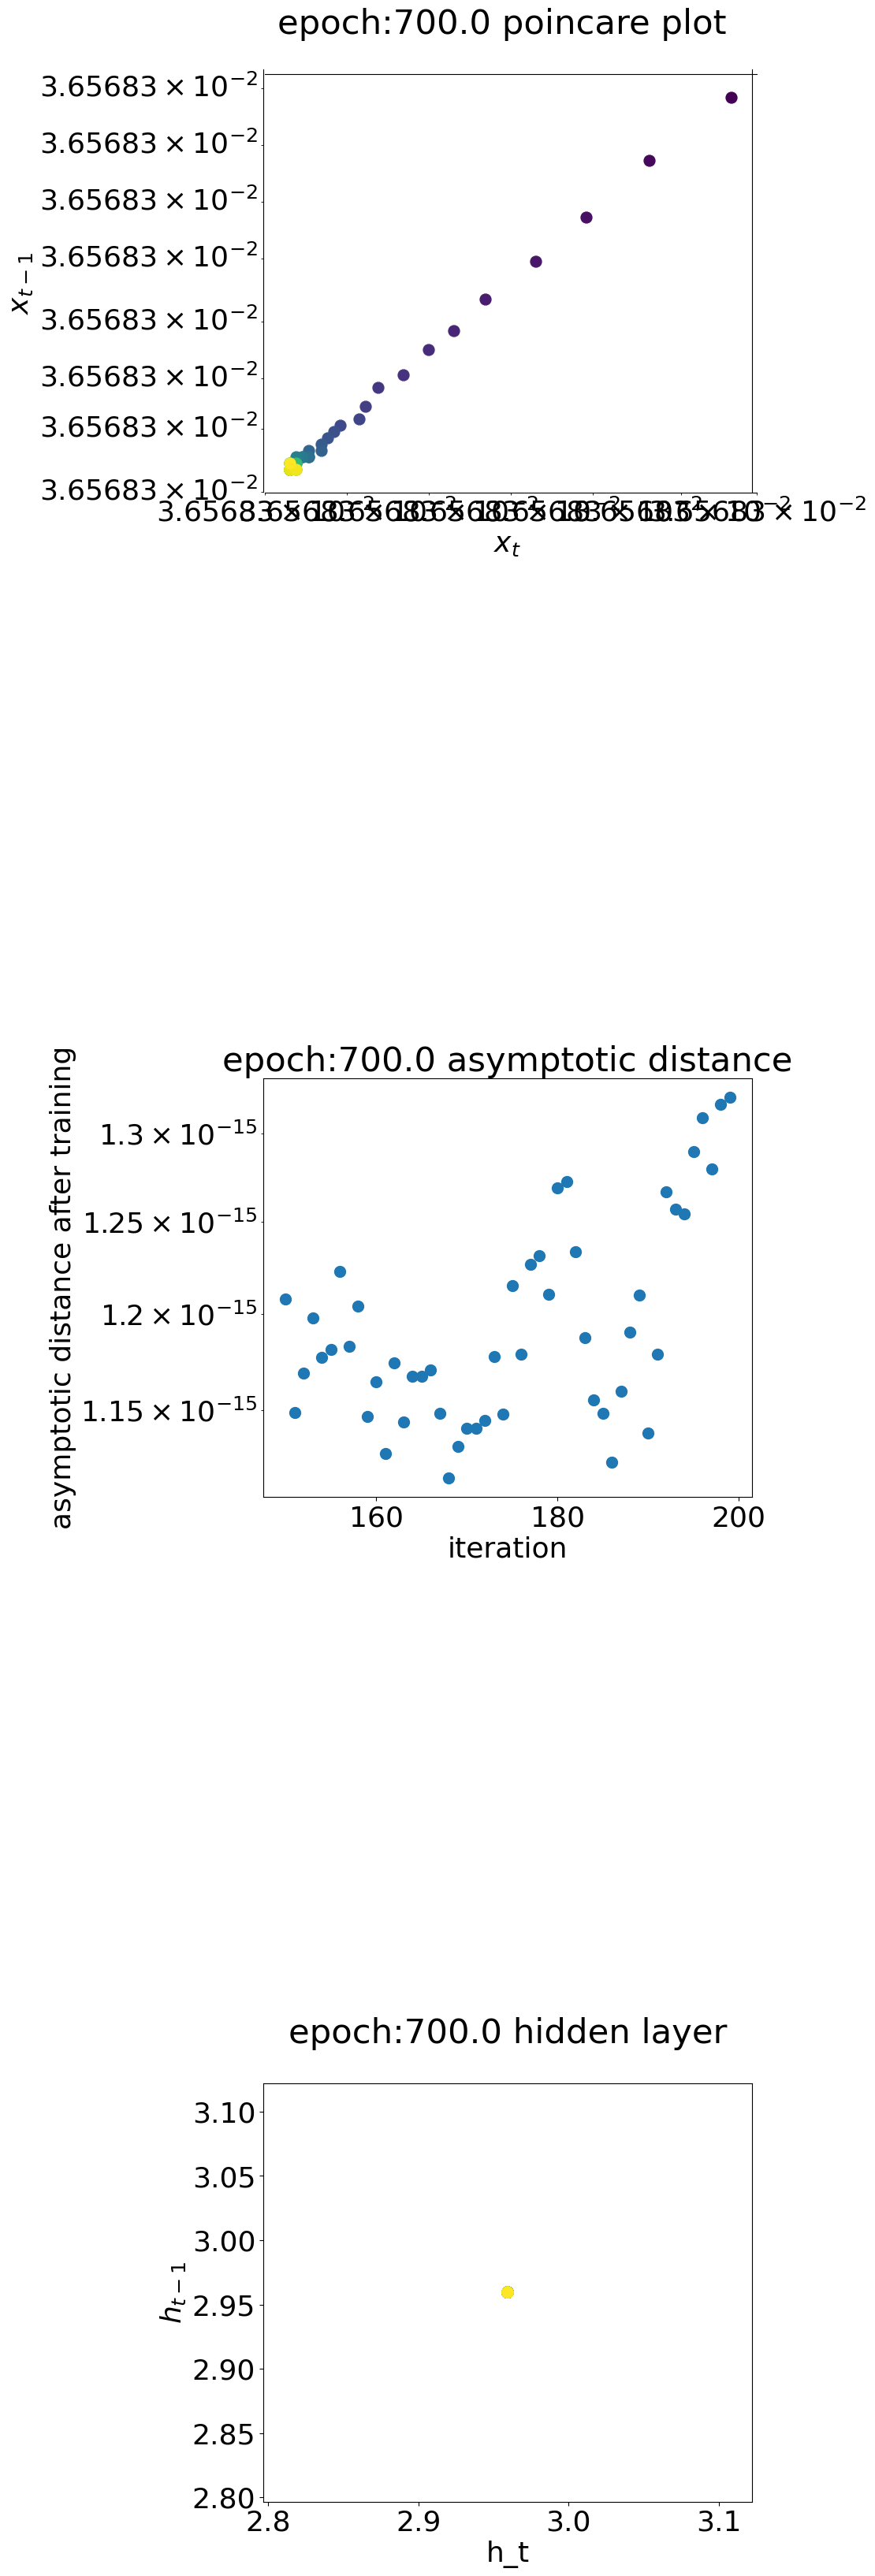

epoch : 701/3000, training loss = 0.053487,validation loss = 0.053579
epoch : 702/3000, training loss = 0.053481,validation loss = 0.053572
epoch : 703/3000, training loss = 0.053475,validation loss = 0.053566
epoch : 704/3000, training loss = 0.053469,validation loss = 0.053560
epoch : 705/3000, training loss = 0.053463,validation loss = 0.053554
epoch : 706/3000, training loss = 0.053456,validation loss = 0.053548
epoch : 707/3000, training loss = 0.053450,validation loss = 0.053542
epoch : 708/3000, training loss = 0.053442,validation loss = 0.053534
epoch : 709/3000, training loss = 0.053434,validation loss = 0.053526
epoch : 710/3000, training loss = 0.053427,validation loss = 0.053518
epoch : 711/3000, training loss = 0.053420,validation loss = 0.053511
epoch : 712/3000, training loss = 0.053413,validation loss = 0.053505
epoch : 713/3000, training loss = 0.053406,validation loss = 0.053498
epoch : 714/3000, training loss = 0.053400,validation loss = 0.053492
epoch : 715/3000, tr

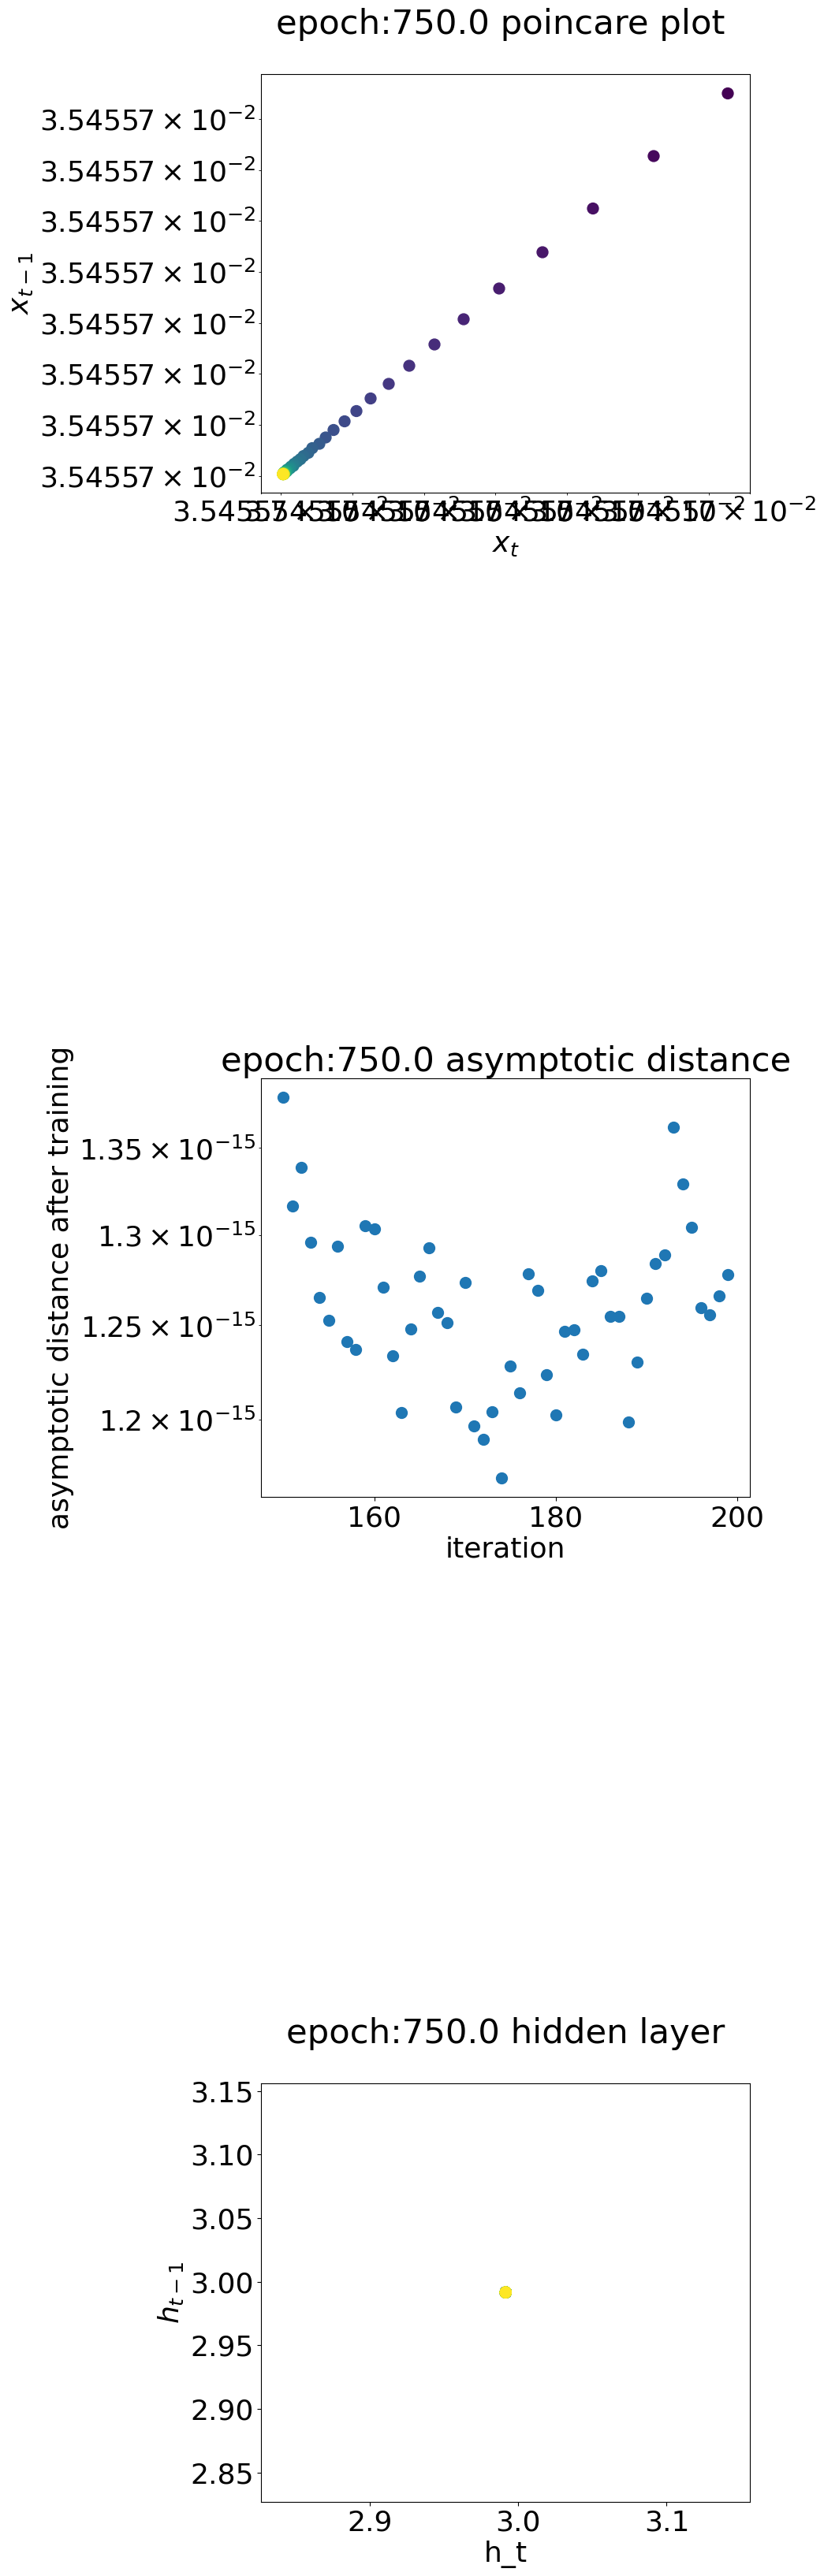

epoch : 751/3000, training loss = 0.052588,validation loss = 0.052688
epoch : 752/3000, training loss = 0.052581,validation loss = 0.052681
epoch : 753/3000, training loss = 0.052574,validation loss = 0.052675
epoch : 754/3000, training loss = 0.052567,validation loss = 0.052667
epoch : 755/3000, training loss = 0.052560,validation loss = 0.052660
epoch : 756/3000, training loss = 0.052553,validation loss = 0.052653
epoch : 757/3000, training loss = 0.052546,validation loss = 0.052646
epoch : 758/3000, training loss = 0.052539,validation loss = 0.052640
epoch : 759/3000, training loss = 0.052532,validation loss = 0.052633
epoch : 760/3000, training loss = 0.052523,validation loss = 0.052617
epoch : 761/3000, training loss = 0.052105,validation loss = 0.052105
epoch : 762/3000, training loss = 0.051985,validation loss = 0.052086
epoch : 763/3000, training loss = 0.051970,validation loss = 0.052074
epoch : 764/3000, training loss = 0.051960,validation loss = 0.052065
epoch : 765/3000, tr

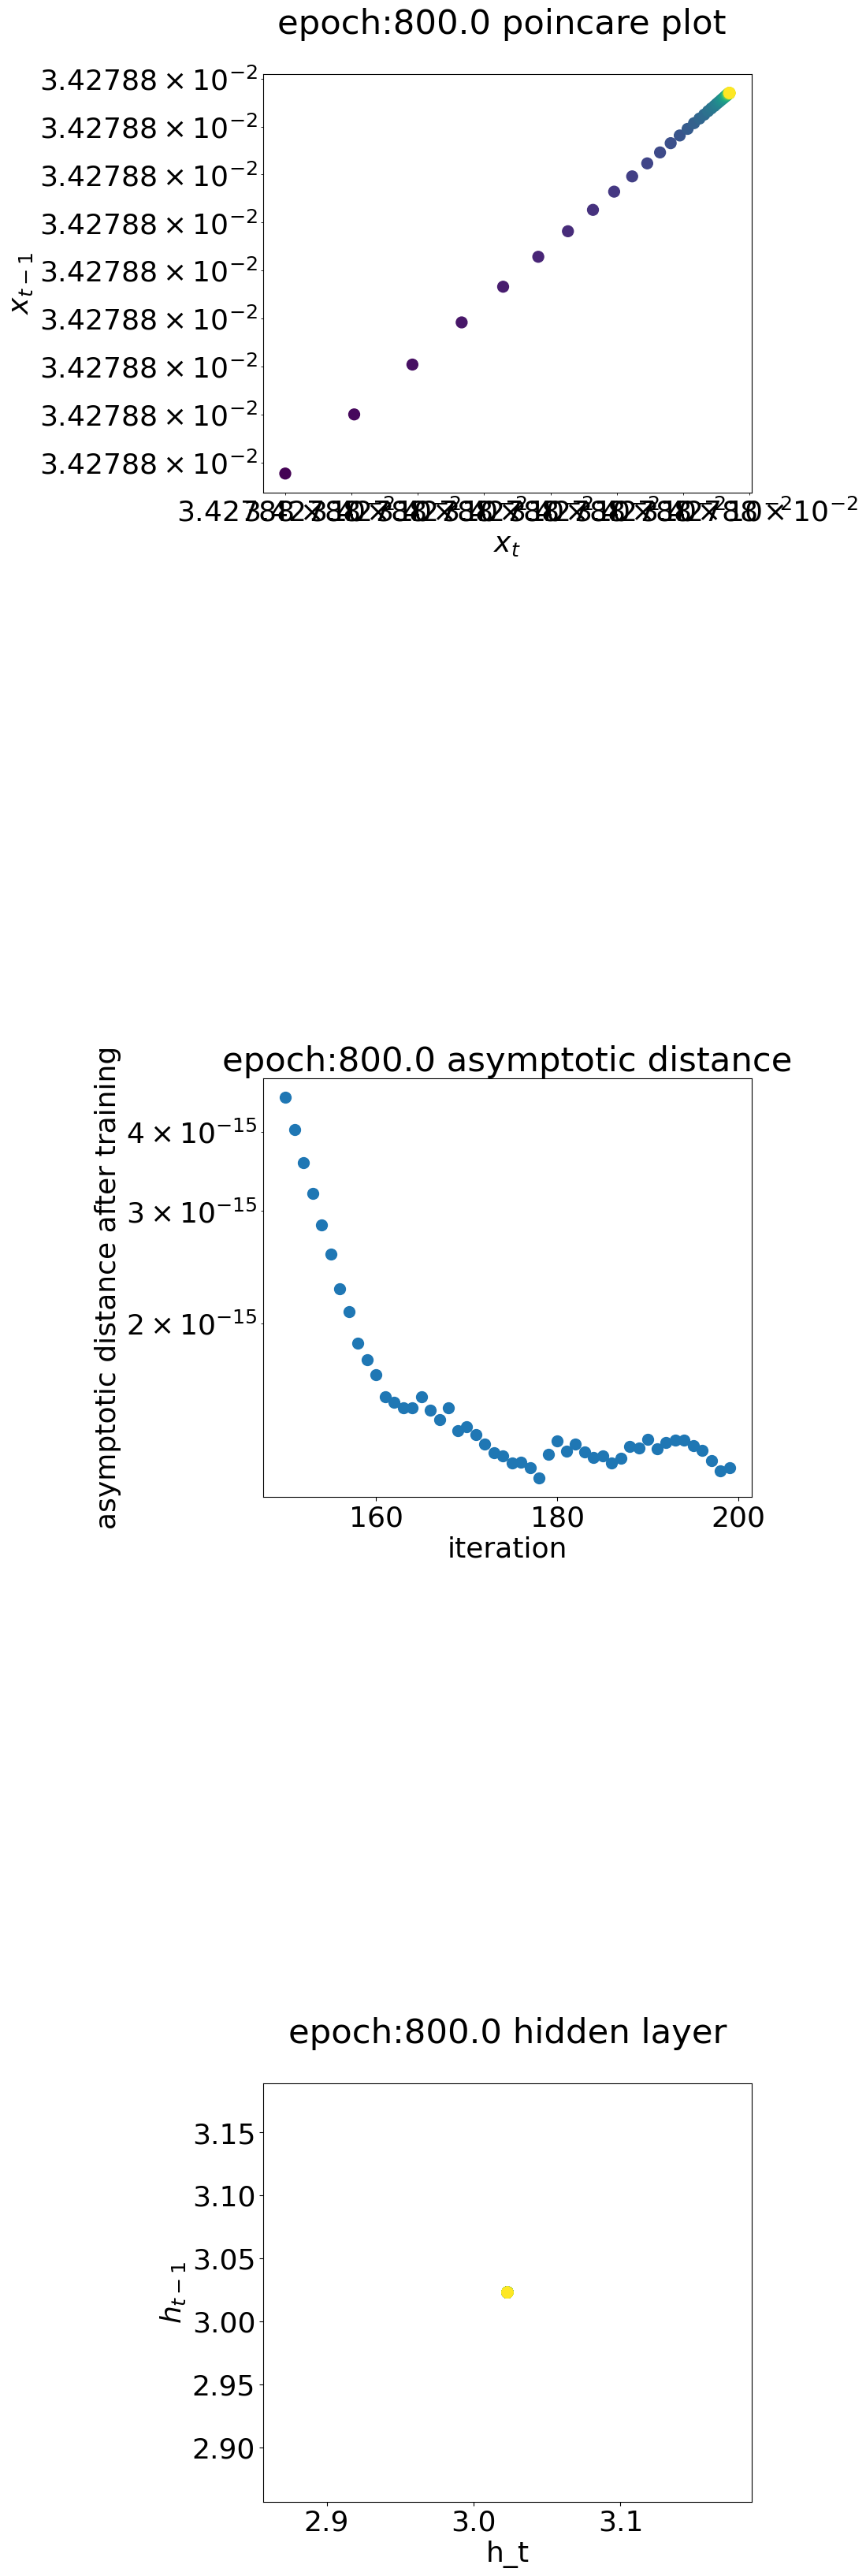

epoch : 801/3000, training loss = 0.051317,validation loss = 0.051423
epoch : 802/3000, training loss = 0.051305,validation loss = 0.051412
epoch : 803/3000, training loss = 0.051295,validation loss = 0.051402
epoch : 804/3000, training loss = 0.051286,validation loss = 0.051393
epoch : 805/3000, training loss = 0.051277,validation loss = 0.051384
epoch : 806/3000, training loss = 0.051268,validation loss = 0.051376
epoch : 807/3000, training loss = 0.051260,validation loss = 0.051367
epoch : 808/3000, training loss = 0.051252,validation loss = 0.051359
epoch : 809/3000, training loss = 0.051244,validation loss = 0.051351
epoch : 810/3000, training loss = 0.051235,validation loss = 0.051343
epoch : 811/3000, training loss = 0.051227,validation loss = 0.051335
epoch : 812/3000, training loss = 0.051219,validation loss = 0.051327
epoch : 813/3000, training loss = 0.051211,validation loss = 0.051319
epoch : 814/3000, training loss = 0.051203,validation loss = 0.051311
epoch : 815/3000, tr

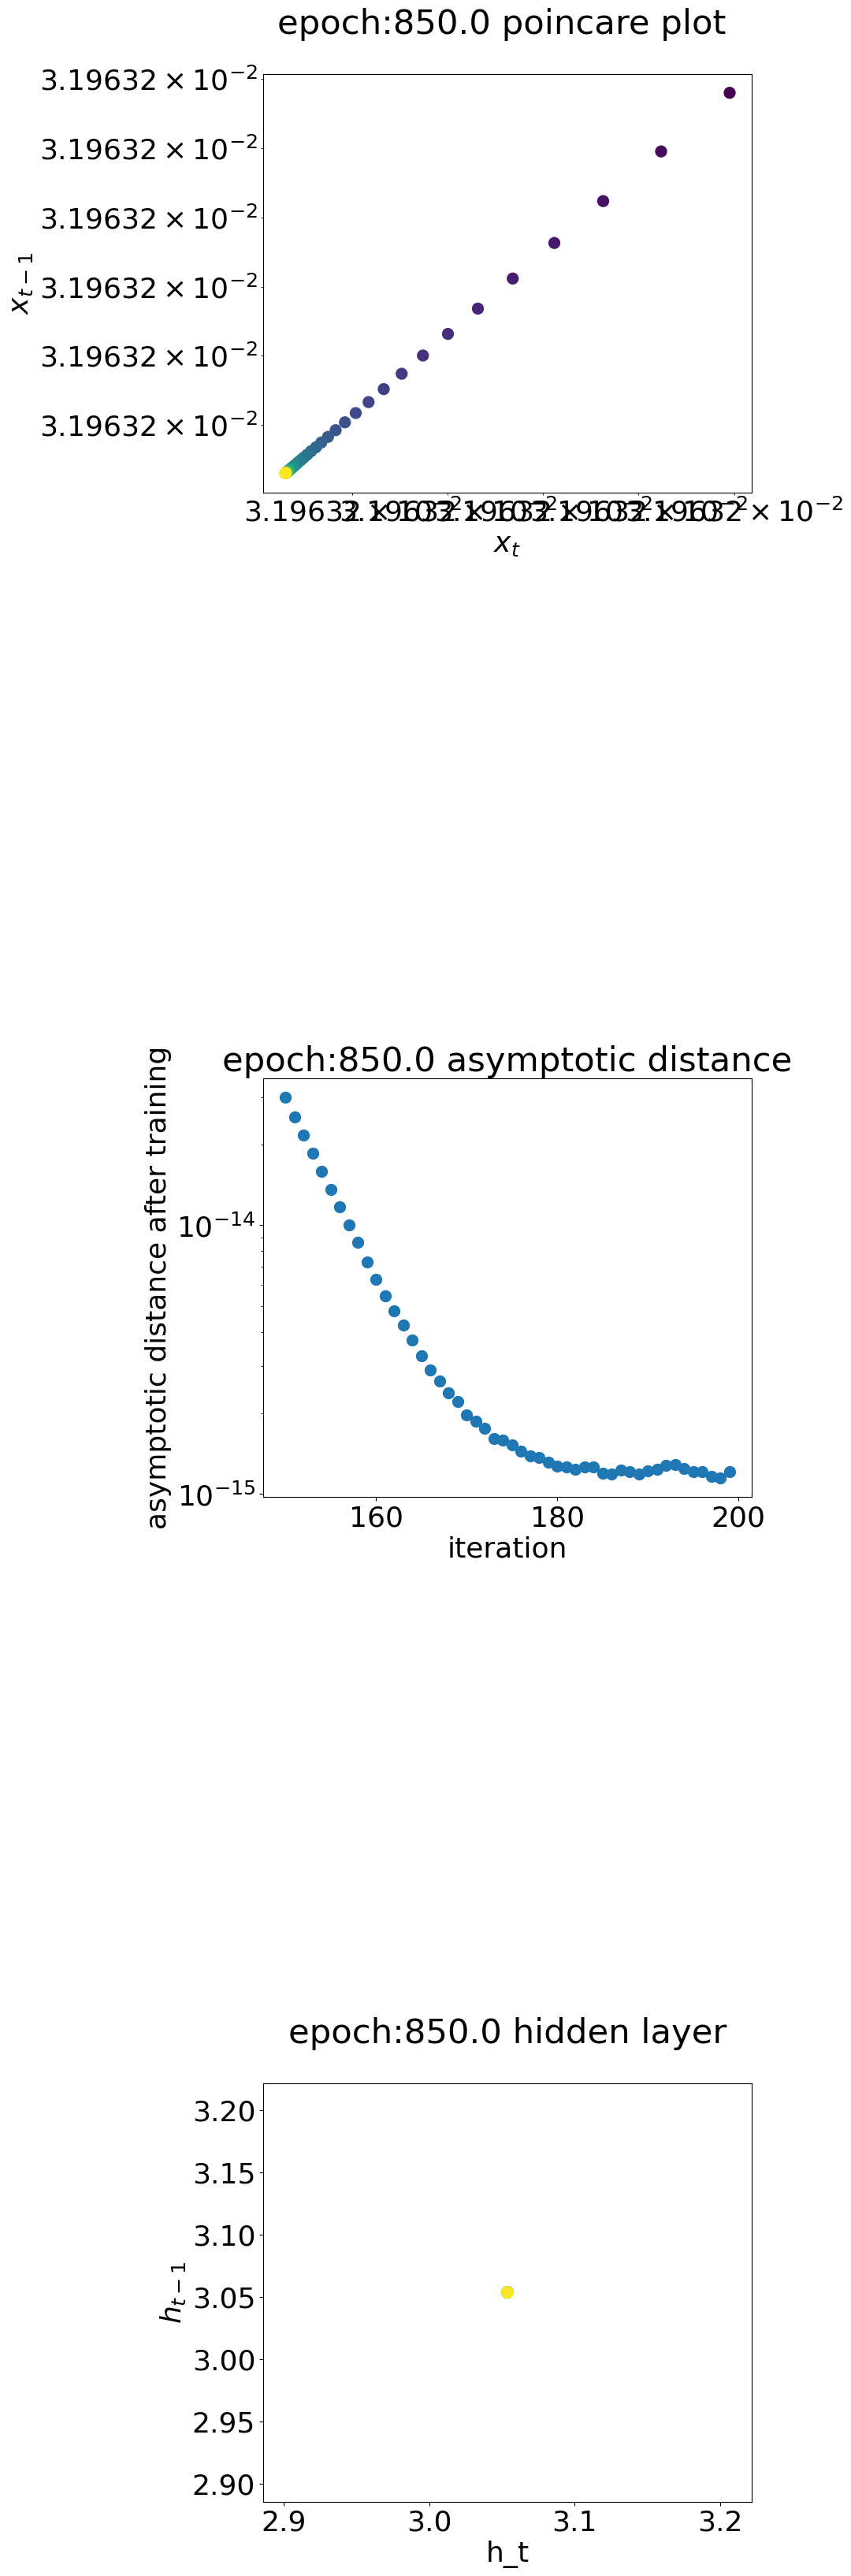

epoch : 851/3000, training loss = 0.050841,validation loss = 0.050946
epoch : 852/3000, training loss = 0.050834,validation loss = 0.050938
epoch : 853/3000, training loss = 0.050826,validation loss = 0.050930
epoch : 854/3000, training loss = 0.050818,validation loss = 0.050922
epoch : 855/3000, training loss = 0.050810,validation loss = 0.050914
epoch : 856/3000, training loss = 0.050802,validation loss = 0.050906
epoch : 857/3000, training loss = 0.050794,validation loss = 0.050898
epoch : 858/3000, training loss = 0.050787,validation loss = 0.050890
epoch : 859/3000, training loss = 0.050779,validation loss = 0.050883
epoch : 860/3000, training loss = 0.050771,validation loss = 0.050875
epoch : 861/3000, training loss = 0.050764,validation loss = 0.050867
epoch : 862/3000, training loss = 0.050756,validation loss = 0.050860
epoch : 863/3000, training loss = 0.050749,validation loss = 0.050852
epoch : 864/3000, training loss = 0.050741,validation loss = 0.050845
epoch : 865/3000, tr

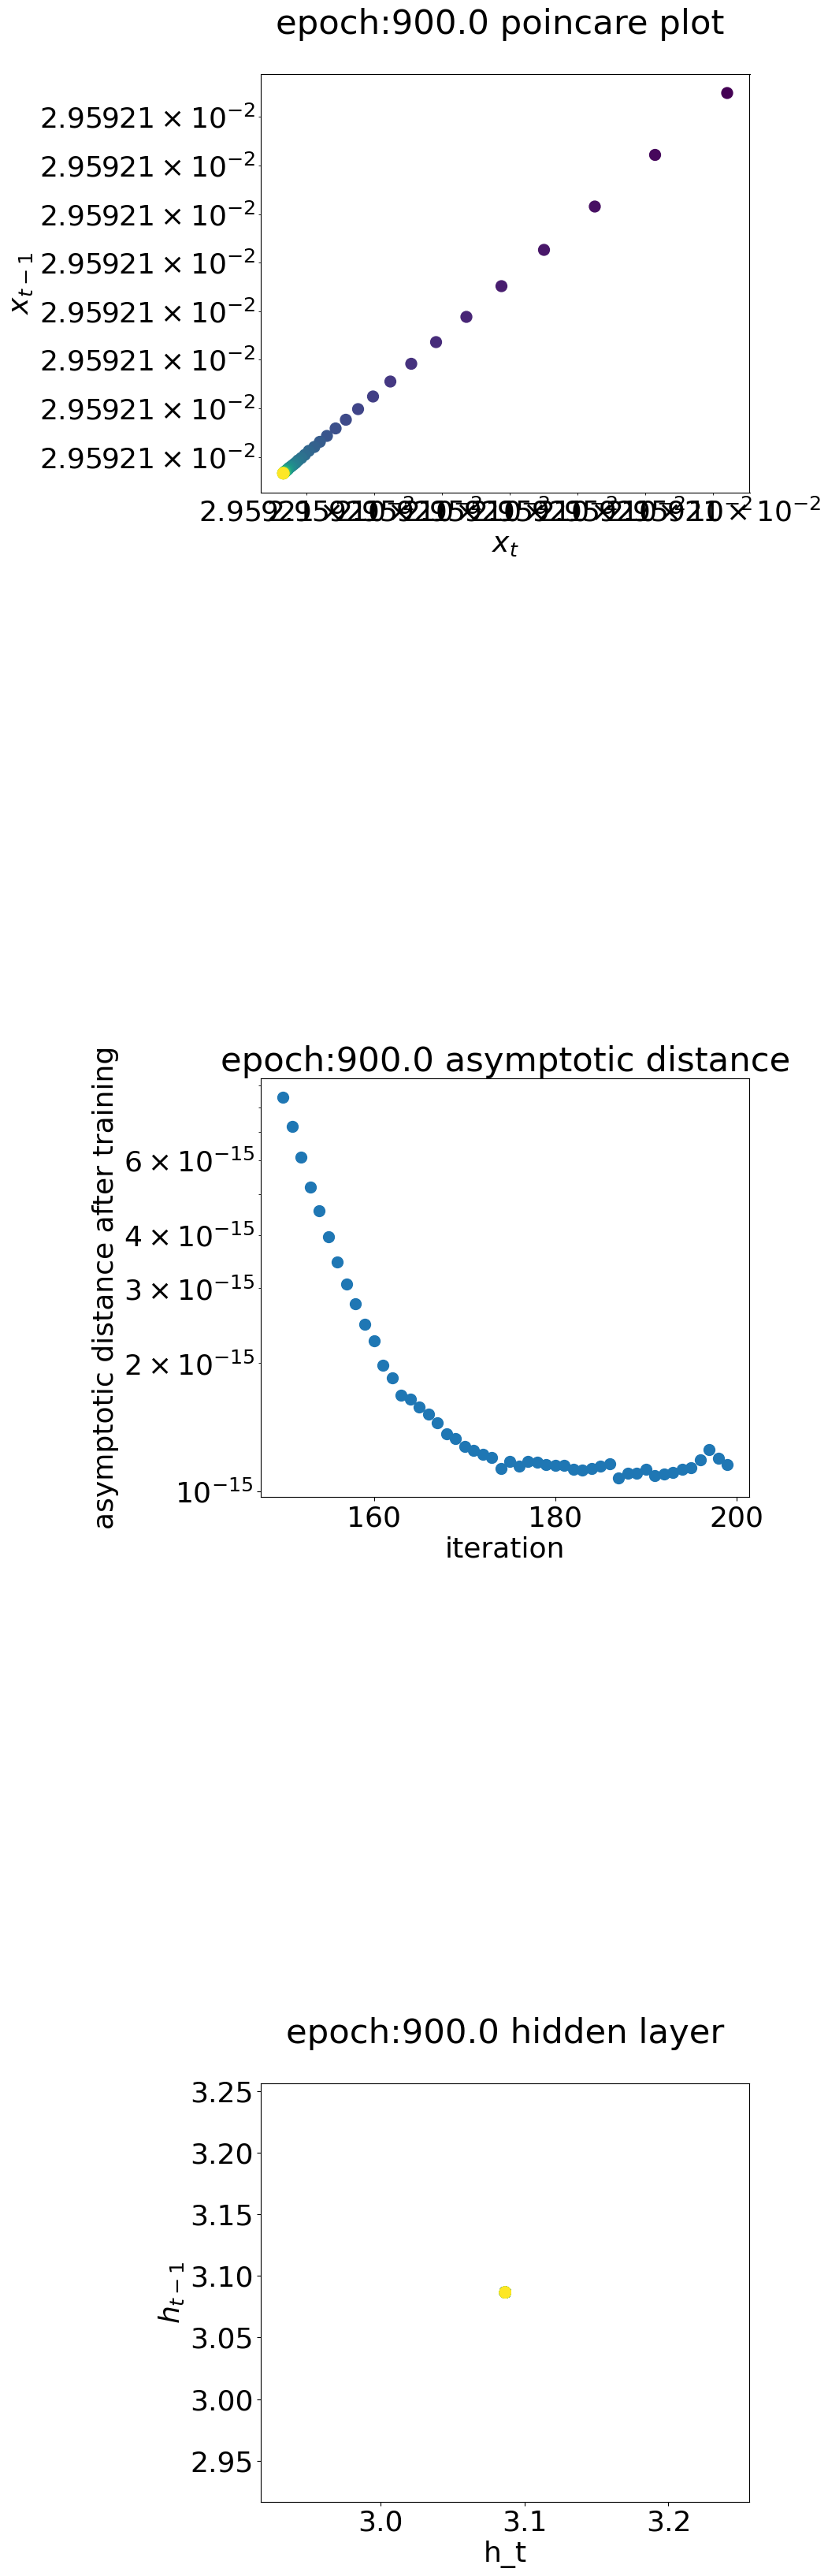

epoch : 901/3000, training loss = 0.050491,validation loss = 0.050592
epoch : 902/3000, training loss = 0.050485,validation loss = 0.050585
epoch : 903/3000, training loss = 0.050479,validation loss = 0.050579
epoch : 904/3000, training loss = 0.050473,validation loss = 0.050573
epoch : 905/3000, training loss = 0.050467,validation loss = 0.050567
epoch : 906/3000, training loss = 0.050461,validation loss = 0.050562
epoch : 907/3000, training loss = 0.050455,validation loss = 0.050555
epoch : 908/3000, training loss = 0.050449,validation loss = 0.050549
epoch : 909/3000, training loss = 0.050443,validation loss = 0.050544
epoch : 910/3000, training loss = 0.050438,validation loss = 0.050538
epoch : 911/3000, training loss = 0.050432,validation loss = 0.050532
epoch : 912/3000, training loss = 0.050426,validation loss = 0.050526
epoch : 913/3000, training loss = 0.050420,validation loss = 0.050520
epoch : 914/3000, training loss = 0.050415,validation loss = 0.050514
epoch : 915/3000, tr

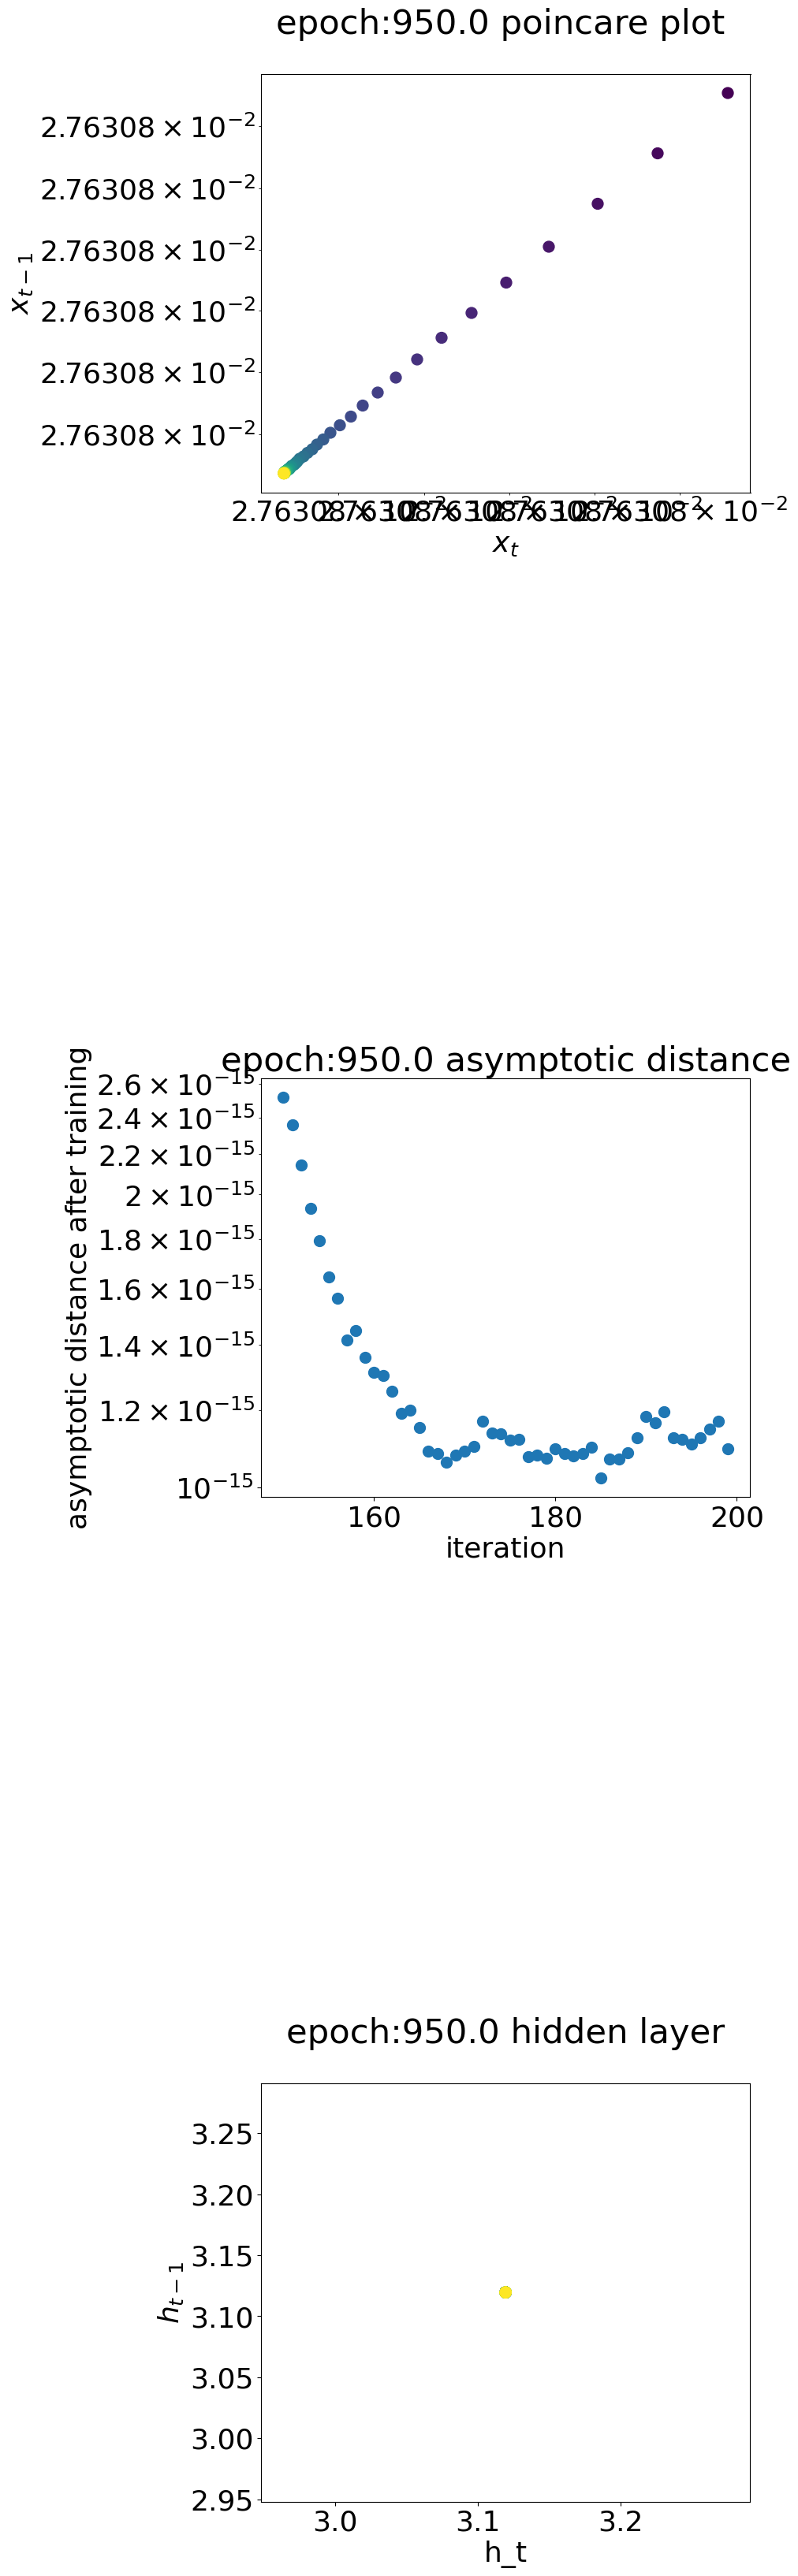

epoch : 951/3000, training loss = 0.050220,validation loss = 0.050320
epoch : 952/3000, training loss = 0.050216,validation loss = 0.050315
epoch : 953/3000, training loss = 0.050211,validation loss = 0.050311
epoch : 954/3000, training loss = 0.050206,validation loss = 0.050306
epoch : 955/3000, training loss = 0.050201,validation loss = 0.050301
epoch : 956/3000, training loss = 0.050196,validation loss = 0.050296
epoch : 957/3000, training loss = 0.050192,validation loss = 0.050292
epoch : 958/3000, training loss = 0.050187,validation loss = 0.050287
epoch : 959/3000, training loss = 0.050182,validation loss = 0.050282
epoch : 960/3000, training loss = 0.050177,validation loss = 0.050277
epoch : 961/3000, training loss = 0.050173,validation loss = 0.050272
epoch : 962/3000, training loss = 0.050168,validation loss = 0.050268
epoch : 963/3000, training loss = 0.050163,validation loss = 0.050263
epoch : 964/3000, training loss = 0.050159,validation loss = 0.050258
epoch : 965/3000, tr

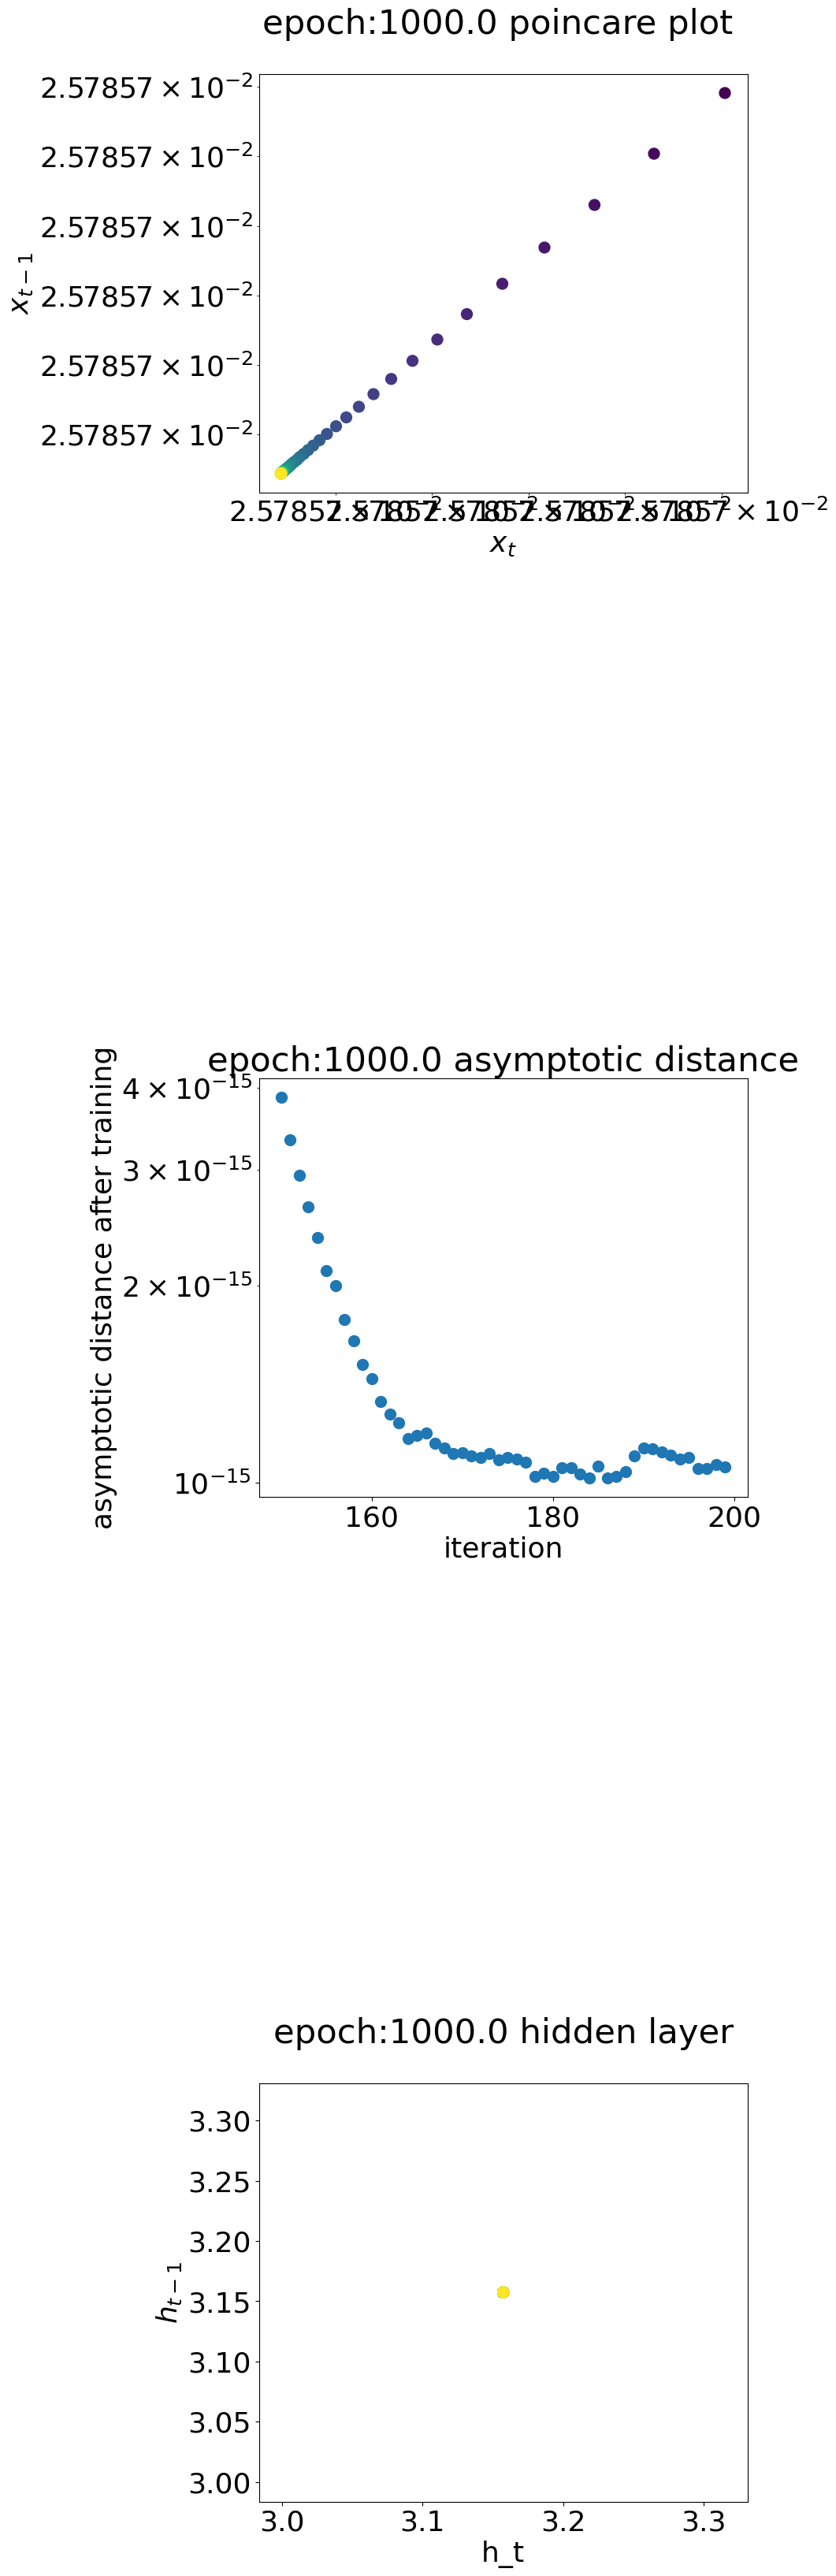

epoch : 1001/3000, training loss = 0.049995,validation loss = 0.050096
epoch : 1002/3000, training loss = 0.049991,validation loss = 0.050091
epoch : 1003/3000, training loss = 0.049987,validation loss = 0.050087
epoch : 1004/3000, training loss = 0.049983,validation loss = 0.050083
epoch : 1005/3000, training loss = 0.049979,validation loss = 0.050079
epoch : 1006/3000, training loss = 0.049974,validation loss = 0.050075
epoch : 1007/3000, training loss = 0.049970,validation loss = 0.050070
epoch : 1008/3000, training loss = 0.049966,validation loss = 0.050067
epoch : 1009/3000, training loss = 0.049962,validation loss = 0.050062
epoch : 1010/3000, training loss = 0.049958,validation loss = 0.050058
epoch : 1011/3000, training loss = 0.049954,validation loss = 0.050054
epoch : 1012/3000, training loss = 0.049949,validation loss = 0.050050
epoch : 1013/3000, training loss = 0.049945,validation loss = 0.050046
epoch : 1014/3000, training loss = 0.049941,validation loss = 0.050042
epoch 

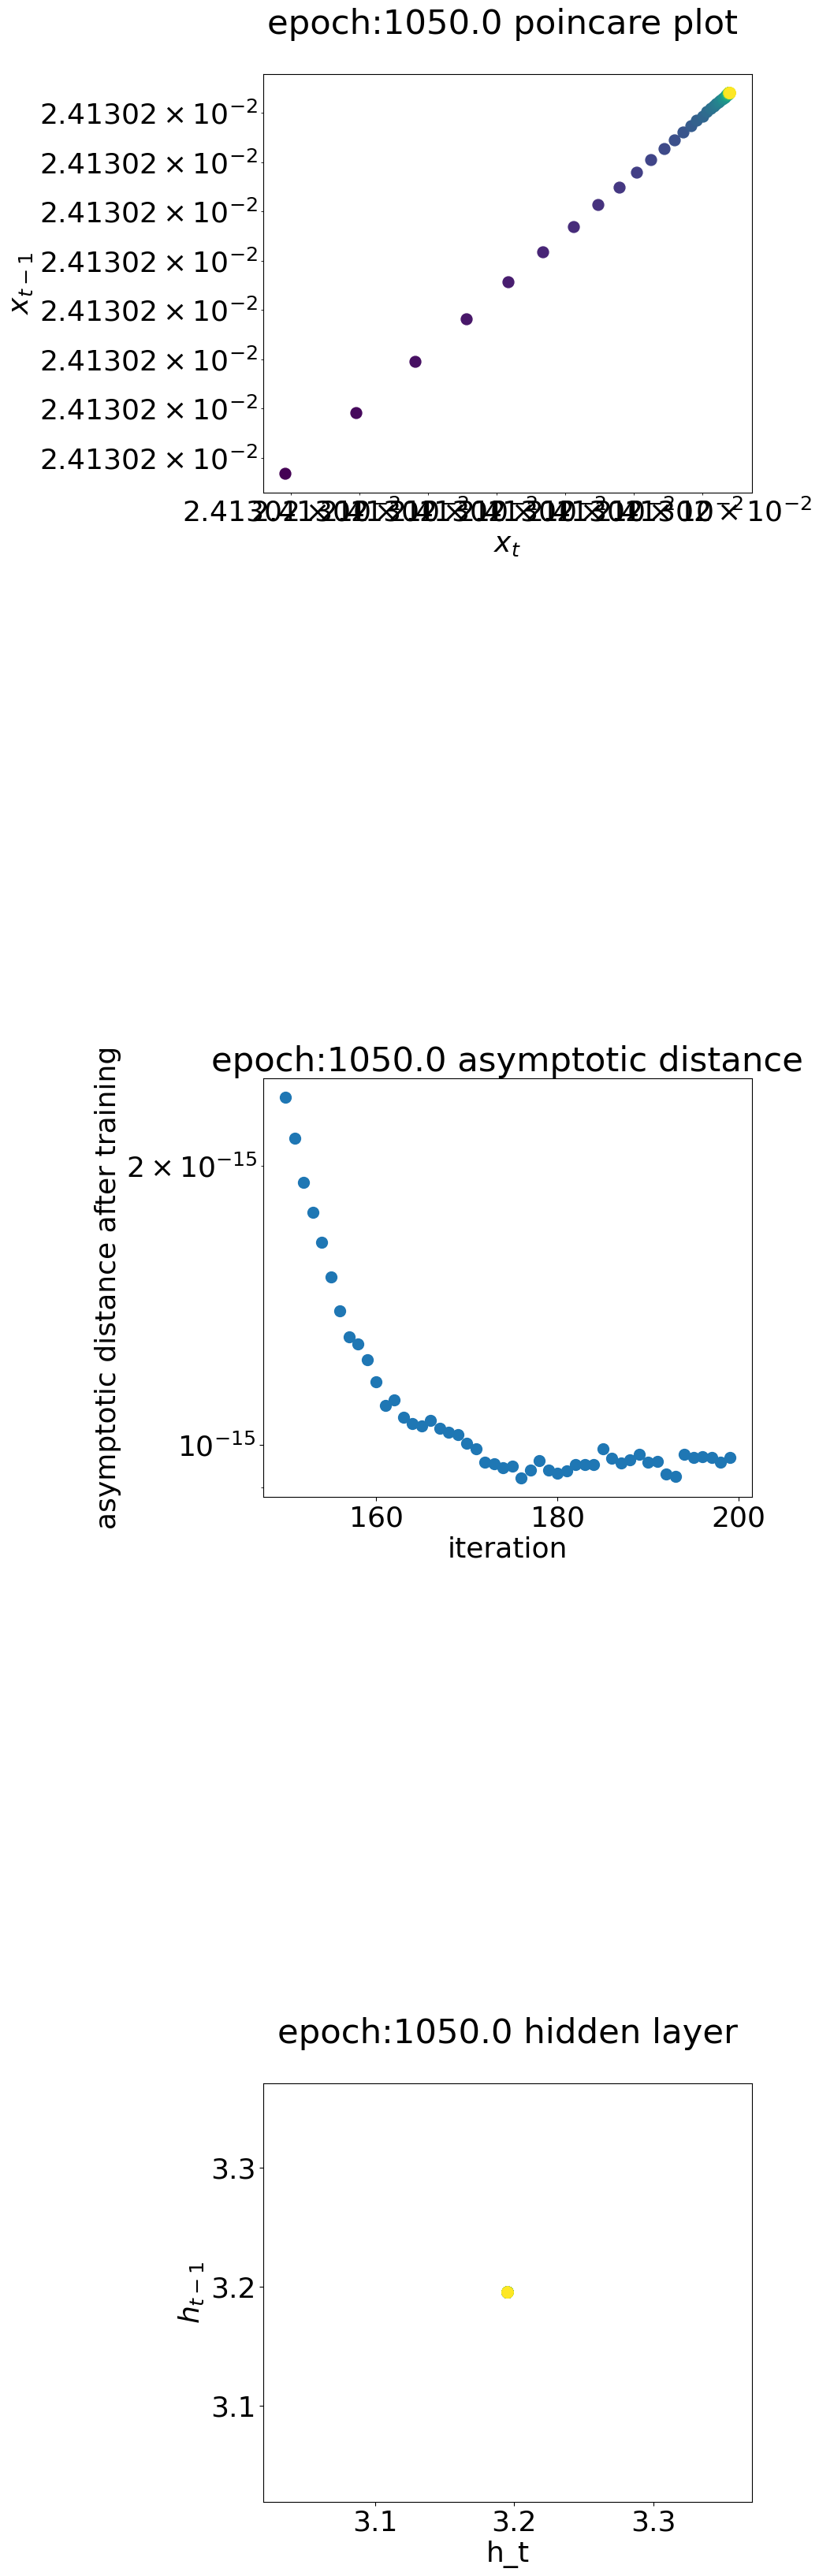

epoch : 1051/3000, training loss = 0.049779,validation loss = 0.049880
epoch : 1052/3000, training loss = 0.049775,validation loss = 0.049876
epoch : 1053/3000, training loss = 0.049771,validation loss = 0.049872
epoch : 1054/3000, training loss = 0.049767,validation loss = 0.049868
epoch : 1055/3000, training loss = 0.049763,validation loss = 0.049864
epoch : 1056/3000, training loss = 0.049759,validation loss = 0.049860
epoch : 1057/3000, training loss = 0.049755,validation loss = 0.049856
epoch : 1058/3000, training loss = 0.049751,validation loss = 0.049853
epoch : 1059/3000, training loss = 0.049747,validation loss = 0.049848
epoch : 1060/3000, training loss = 0.049740,validation loss = 0.049839
epoch : 1061/3000, training loss = 0.049733,validation loss = 0.049835
epoch : 1062/3000, training loss = 0.049729,validation loss = 0.049831
epoch : 1063/3000, training loss = 0.049725,validation loss = 0.049827
epoch : 1064/3000, training loss = 0.049720,validation loss = 0.049823
epoch 

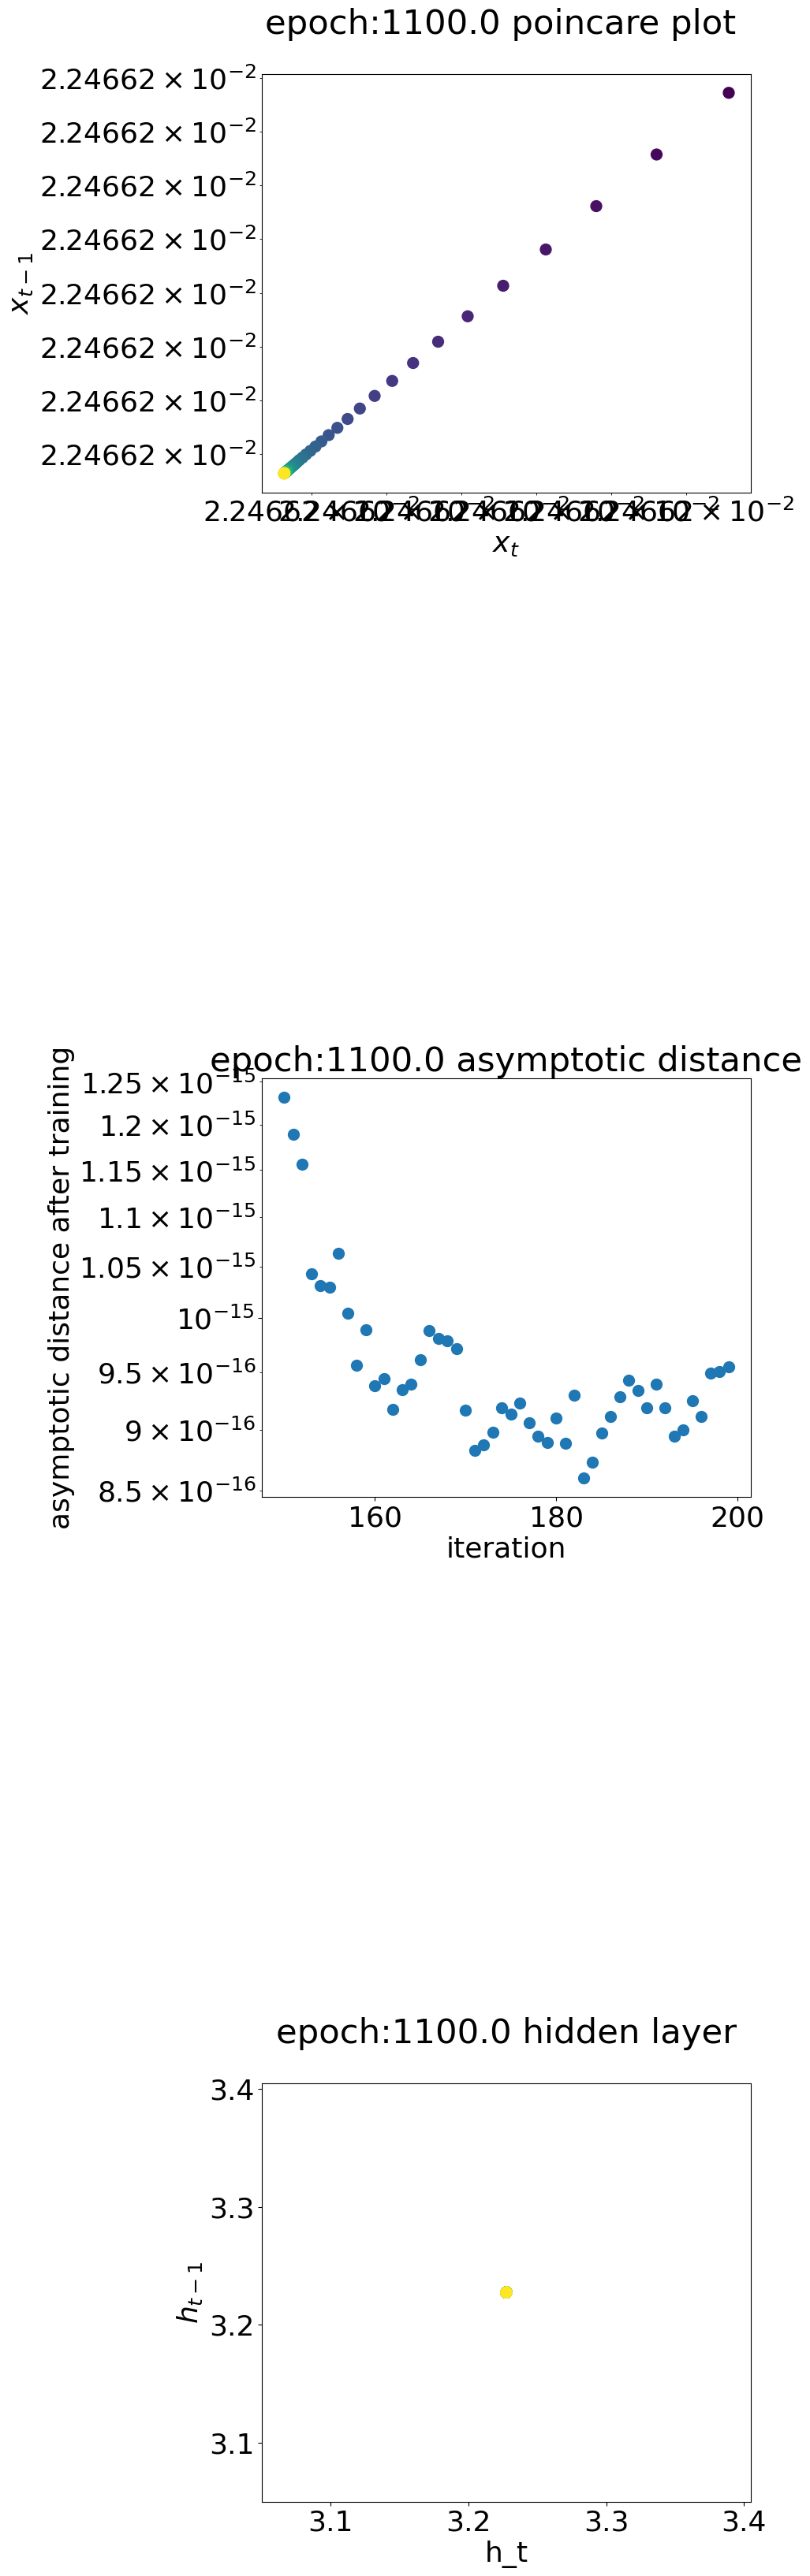

epoch : 1101/3000, training loss = 0.049550,validation loss = 0.049651
epoch : 1102/3000, training loss = 0.049546,validation loss = 0.049647
epoch : 1103/3000, training loss = 0.049542,validation loss = 0.049643
epoch : 1104/3000, training loss = 0.049473,validation loss = 0.049513
epoch : 1105/3000, training loss = 0.049389,validation loss = 0.049485
epoch : 1106/3000, training loss = 0.049378,validation loss = 0.049478
epoch : 1107/3000, training loss = 0.049330,validation loss = 0.049411
epoch : 1108/3000, training loss = 0.049260,validation loss = 0.049228
epoch : 1109/3000, training loss = 0.049073,validation loss = 0.049159
epoch : 1110/3000, training loss = 0.049047,validation loss = 0.049142
epoch : 1111/3000, training loss = 0.049033,validation loss = 0.049130
epoch : 1112/3000, training loss = 0.049022,validation loss = 0.049121
epoch : 1113/3000, training loss = 0.049014,validation loss = 0.049113
epoch : 1114/3000, training loss = 0.049006,validation loss = 0.049105
epoch 

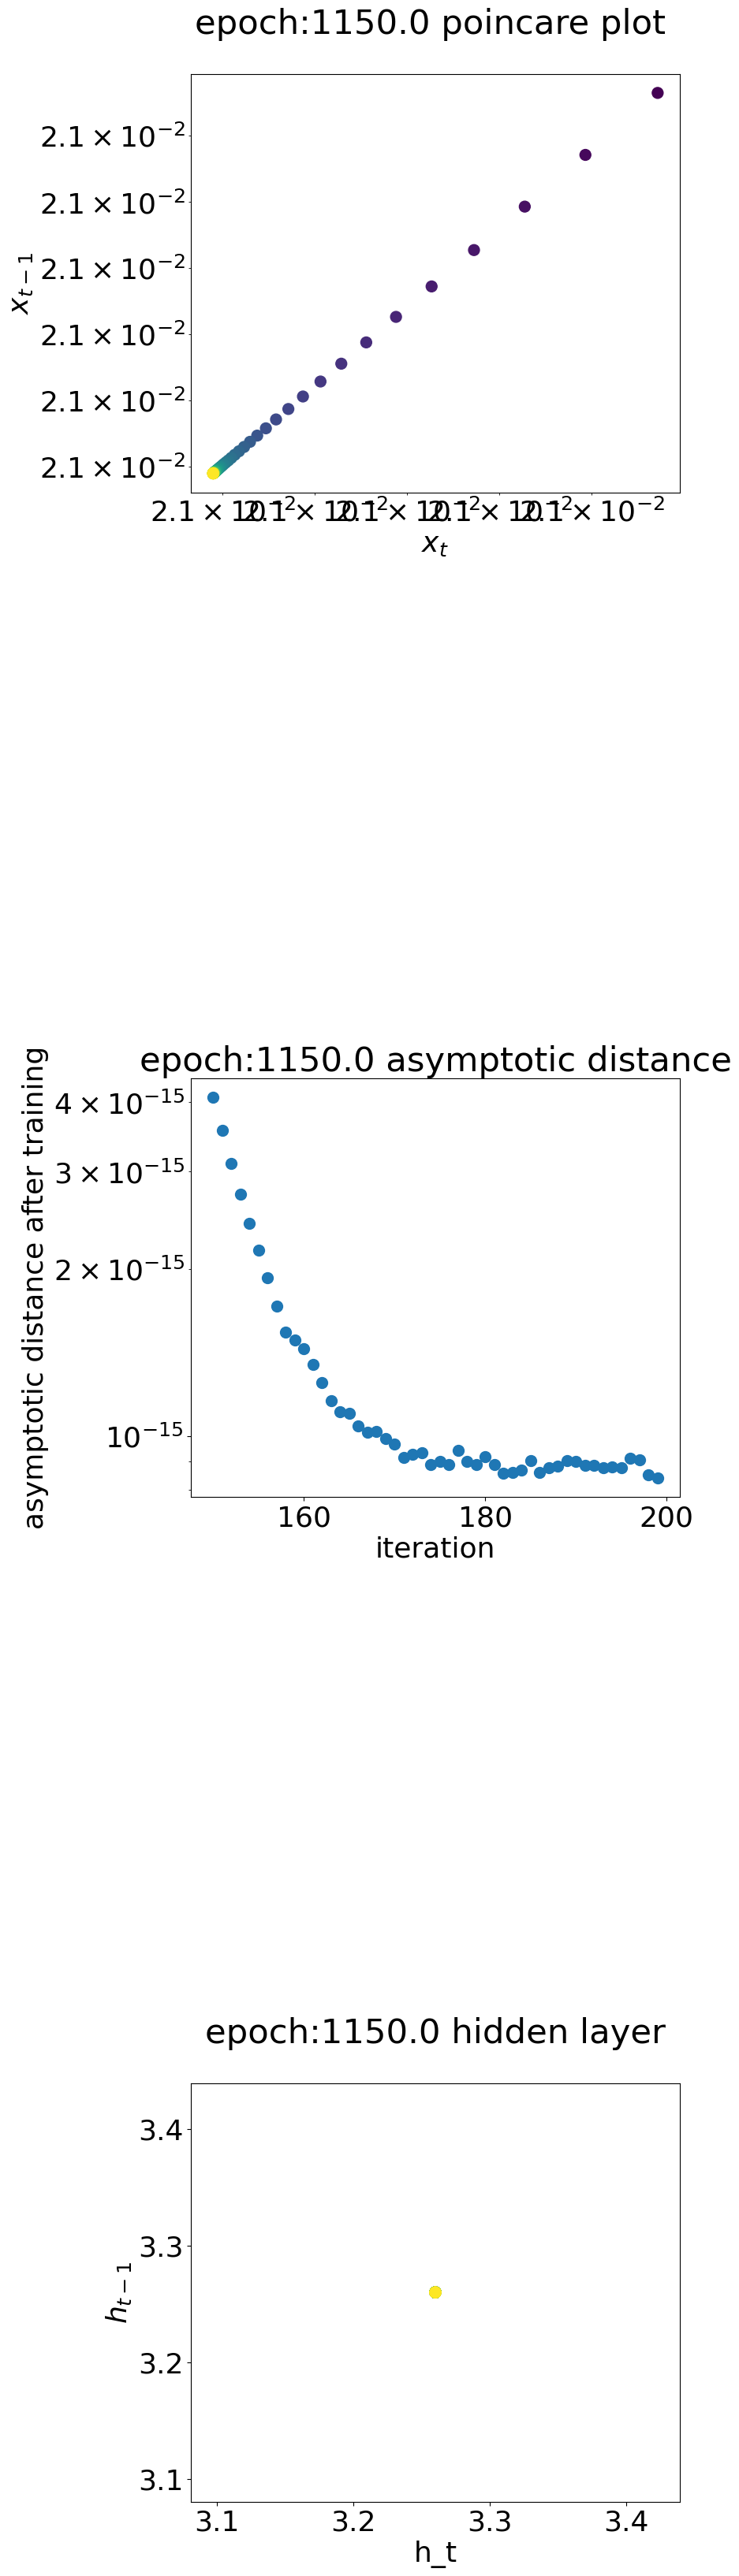

epoch : 1151/3000, training loss = 0.048141,validation loss = 0.048240
epoch : 1152/3000, training loss = 0.048137,validation loss = 0.048236
epoch : 1153/3000, training loss = 0.048132,validation loss = 0.048232
epoch : 1154/3000, training loss = 0.048128,validation loss = 0.048227
epoch : 1155/3000, training loss = 0.048123,validation loss = 0.048223
epoch : 1156/3000, training loss = 0.048119,validation loss = 0.048218
epoch : 1157/3000, training loss = 0.048114,validation loss = 0.048214
epoch : 1158/3000, training loss = 0.048110,validation loss = 0.048210
epoch : 1159/3000, training loss = 0.048106,validation loss = 0.048206
epoch : 1160/3000, training loss = 0.048101,validation loss = 0.048201
epoch : 1161/3000, training loss = 0.048097,validation loss = 0.048197
epoch : 1162/3000, training loss = 0.048093,validation loss = 0.048192
epoch : 1163/3000, training loss = 0.048088,validation loss = 0.048188
epoch : 1164/3000, training loss = 0.048084,validation loss = 0.048184
epoch 

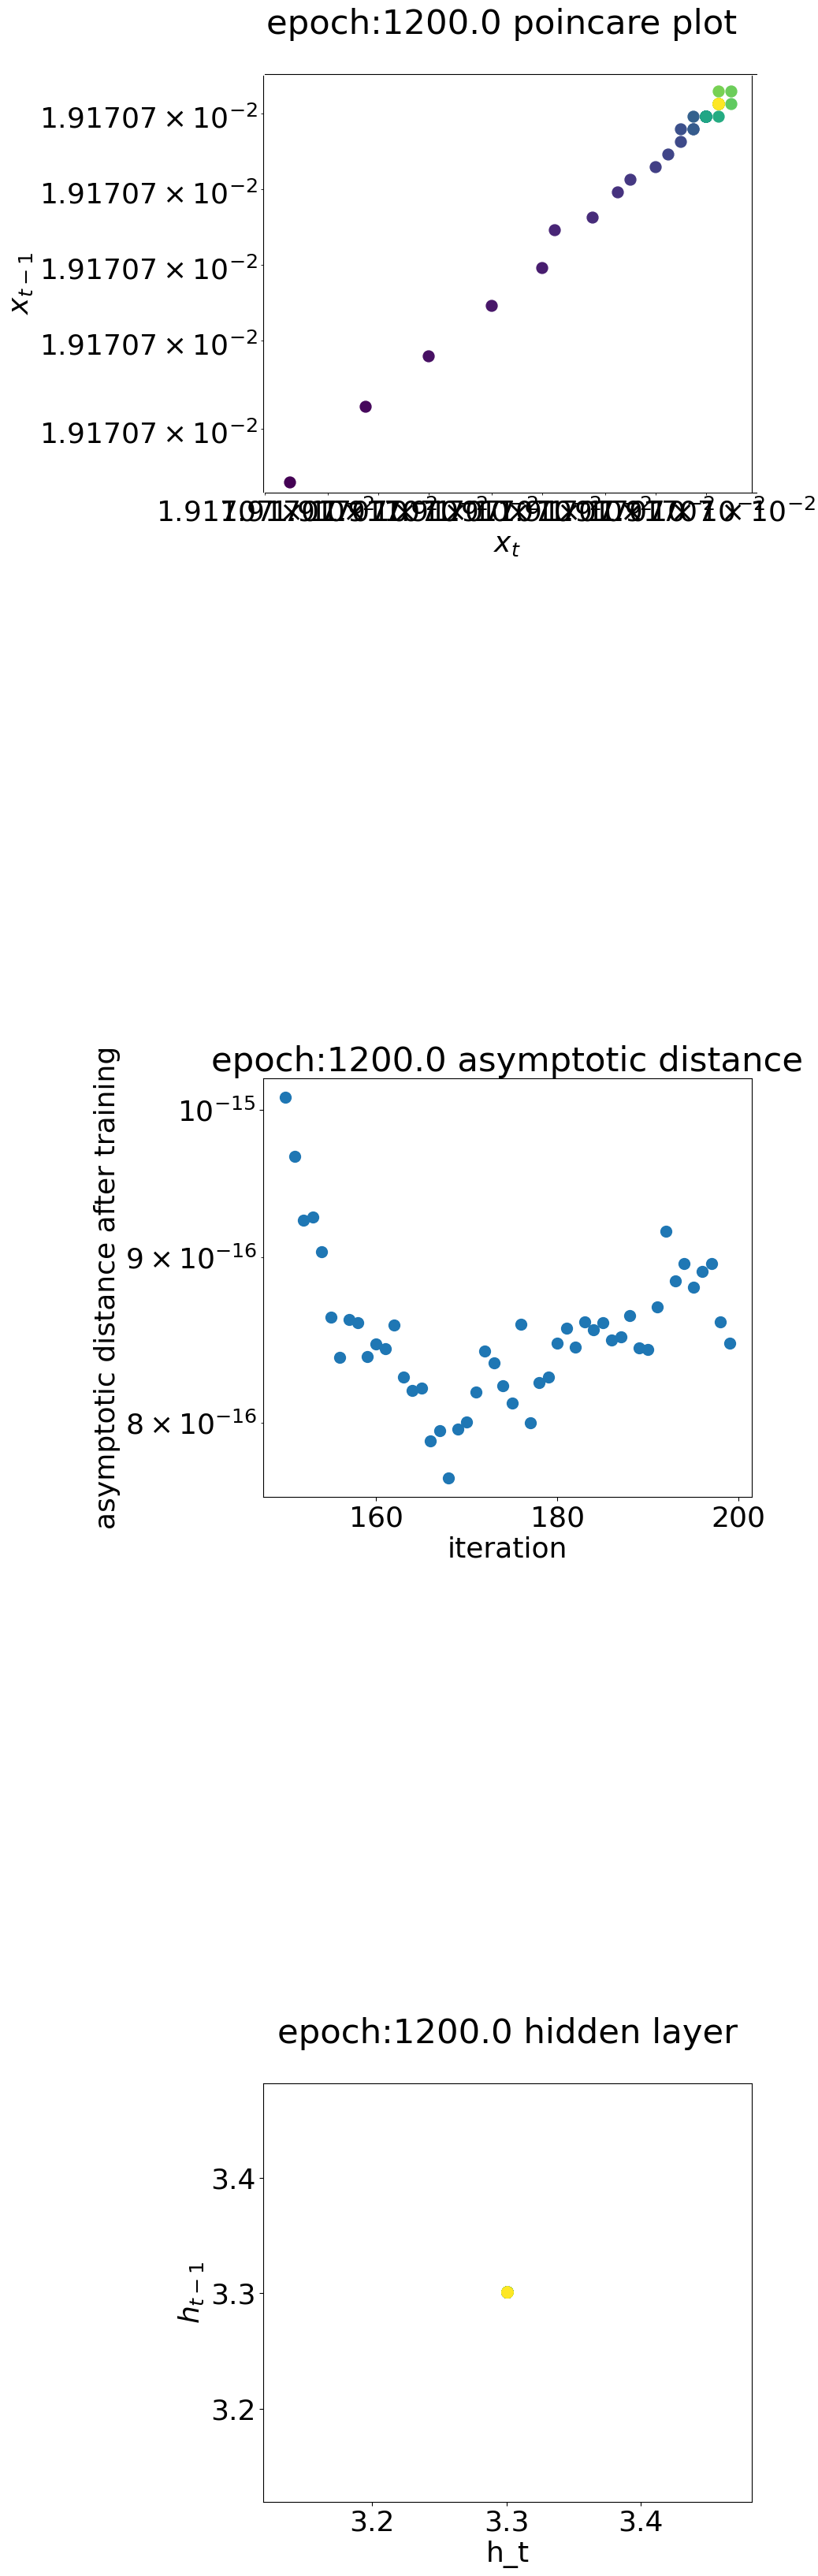

epoch : 1201/3000, training loss = 0.047740,validation loss = 0.047841
epoch : 1202/3000, training loss = 0.047736,validation loss = 0.047836
epoch : 1203/3000, training loss = 0.047732,validation loss = 0.047832
epoch : 1204/3000, training loss = 0.047728,validation loss = 0.047829
epoch : 1205/3000, training loss = 0.047724,validation loss = 0.047825
epoch : 1206/3000, training loss = 0.047720,validation loss = 0.047821
epoch : 1207/3000, training loss = 0.047716,validation loss = 0.047817
epoch : 1208/3000, training loss = 0.047712,validation loss = 0.047813
epoch : 1209/3000, training loss = 0.047708,validation loss = 0.047809
epoch : 1210/3000, training loss = 0.047704,validation loss = 0.047805
epoch : 1211/3000, training loss = 0.047700,validation loss = 0.047801
epoch : 1212/3000, training loss = 0.047696,validation loss = 0.047797
epoch : 1213/3000, training loss = 0.047692,validation loss = 0.047793
epoch : 1214/3000, training loss = 0.047688,validation loss = 0.047789
epoch 

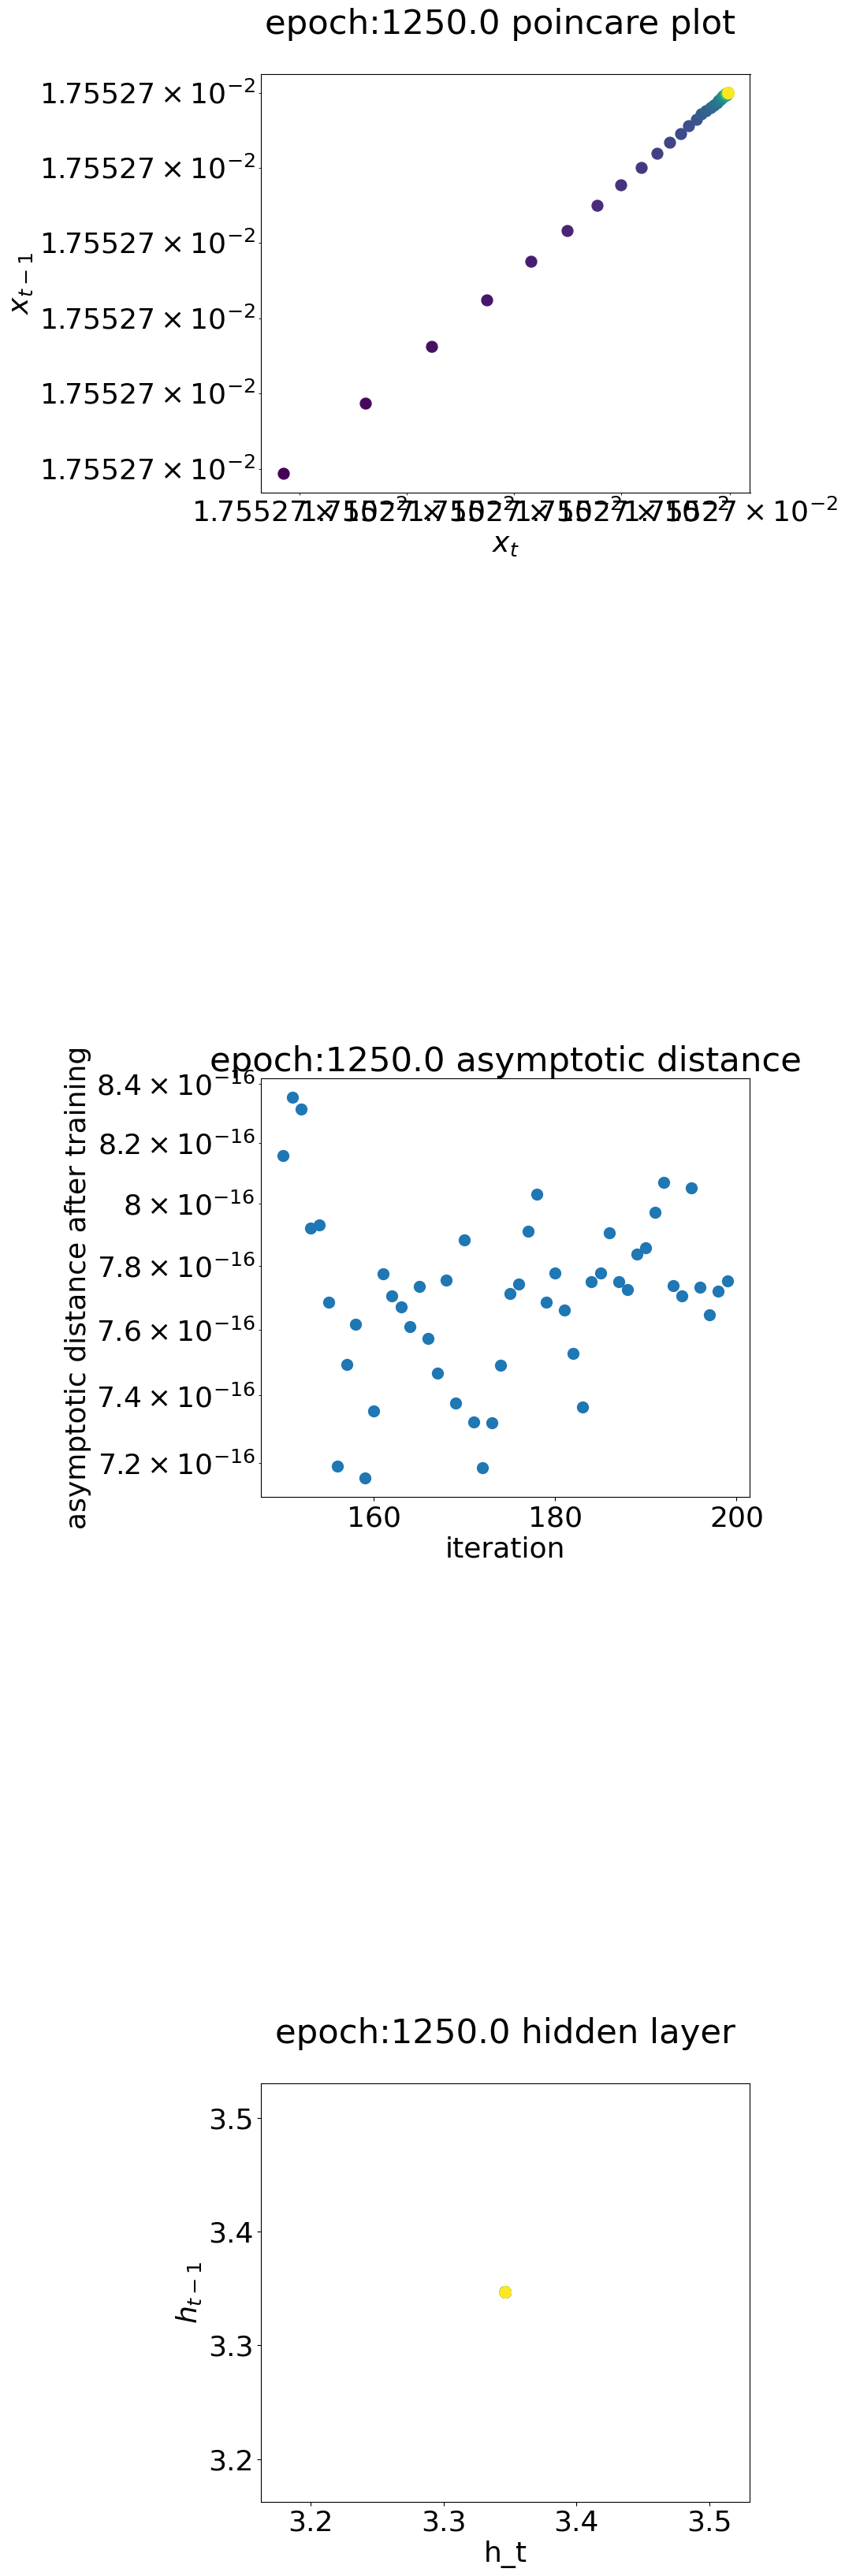

epoch : 1251/3000, training loss = 0.047549,validation loss = 0.047653
epoch : 1252/3000, training loss = 0.047545,validation loss = 0.047650
epoch : 1253/3000, training loss = 0.047542,validation loss = 0.047646
epoch : 1254/3000, training loss = 0.047538,validation loss = 0.047643
epoch : 1255/3000, training loss = 0.047535,validation loss = 0.047639
epoch : 1256/3000, training loss = 0.047531,validation loss = 0.047636
epoch : 1257/3000, training loss = 0.047528,validation loss = 0.047633
epoch : 1258/3000, training loss = 0.047524,validation loss = 0.047629
epoch : 1259/3000, training loss = 0.047521,validation loss = 0.047626
epoch : 1260/3000, training loss = 0.047517,validation loss = 0.047623
epoch : 1261/3000, training loss = 0.047514,validation loss = 0.047619
epoch : 1262/3000, training loss = 0.047510,validation loss = 0.047616
epoch : 1263/3000, training loss = 0.047507,validation loss = 0.047612
epoch : 1264/3000, training loss = 0.047503,validation loss = 0.047609
epoch 

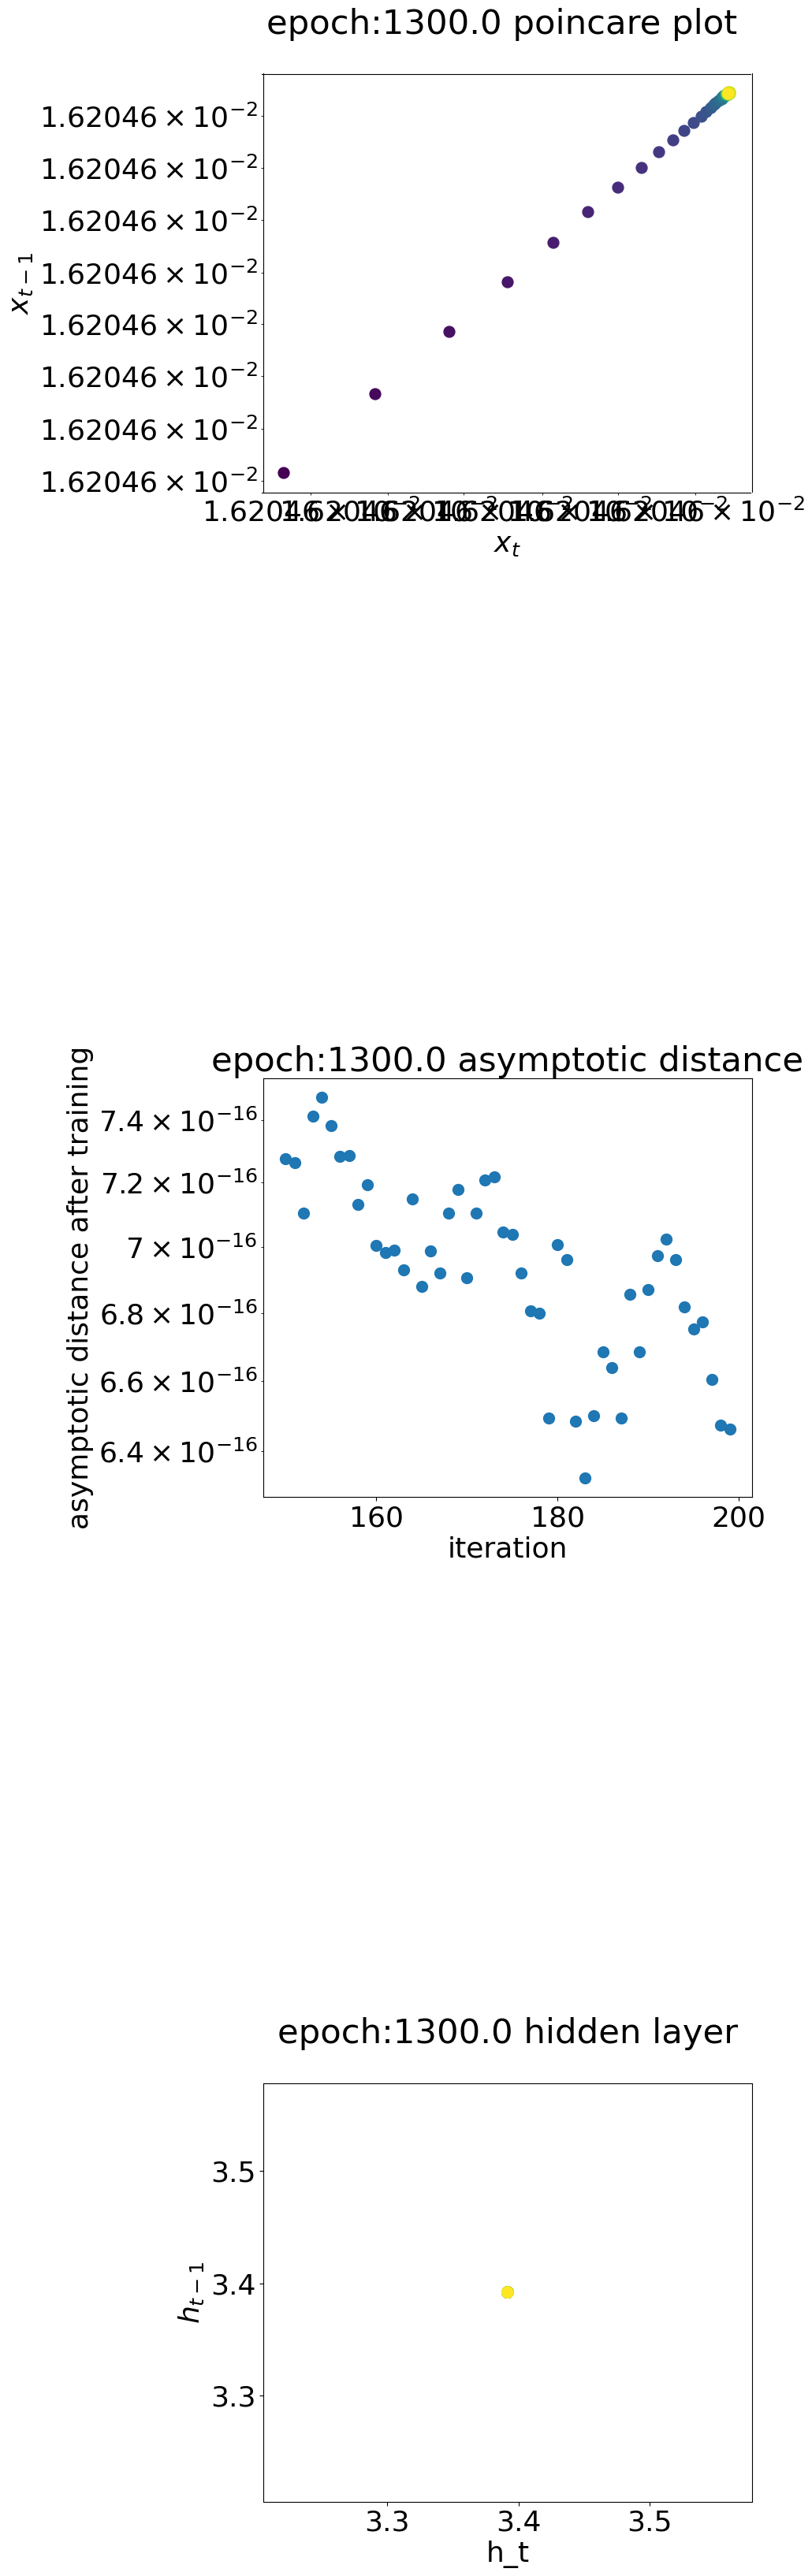

epoch : 1301/3000, training loss = 0.047382,validation loss = 0.047490
epoch : 1302/3000, training loss = 0.047379,validation loss = 0.047487


In [ ]:

spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
#diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=True
chao=[]
noise_print=False
for epoch in range(epochs):
    loss = 0


    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        batch_feature=batch_features.view(batch_size,-1)
        #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature.to(device))
        
        if init_compute==True and epoch%interval==0:
                #print("here")Trues 
                #print(train_loss)
            save_image=input_image
                #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
            perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
                #print("perturbed_inputs")
                #print(torch.norm(perturbed_inputs))
            cutoff=[]
            for j in range(no_of_images):
                cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
            model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer)
            model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
            #model_clone.eval() 
            #print(cutoff)
            x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
            x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
            #print("there")
            ##print(torch.norm(y_pred_perturbed))
            #print(torch.norm(y_pred_unperturbed))
            distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
                
            asymptotic_dist.append(distance[-1])
            chao.append(chaos)
            
            plt.scatter(x=np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),y=distance,s=100)
            plt.xlabel("iteration")
            plt.ylabel("asymptotic distance")
            plt.yscale("log")
            plt.title("epoch:{:.1f} asymptotic distance before training".format(epoch))
            np.savetxt("asymptotic distance.txt"+str(epoch),distance)
            plt.savefig("initial asymptotic state.jpg")
            plt.show()
            #average_jacobian=[]
            #spectral_radiuses=[]
            init_compute=False
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)

    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
        
        
    print("epoch : {}/{}, training loss = {:.6f},validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        #dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train_unperturbed[0],dimension_vector,no_of_repetition,colour,epoch)
        #name="asymptotic image input"
#         #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
#         #x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
        perturbed_input=add_gaussian_noise(save_image,perturbation_strength)
        cutoffs=[]
        for j in range(no_of_images):
            cutoffs.append(torch.norm(perturbed_input[j]-save_image[j]))
        #print(cutoffs)
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_input,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,save_image,epoch)
        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoffs)
                

        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train_perturbed[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
         #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
     
       
         #perturbed_inputs=add_powerlaw_noise(input_size,batch_size,perturbation_strength,x_train.cpu()).view(batch_size, -1).to(device)
         #distance,hidden,chaos=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
        print("percentage of chaos:",chaos) 
        
        asymptotic_dist.append(distance[-1])
         #print(distance[-1])
        inits=0
        if epoch==epochs-1:
            for value in model.parameters():
                 #print(key)
                plots=torch.flatten(value).cpu().detach().numpy()
                plt.hist(plots, density=True, bins='auto', histtype='stepfilled',cumulative=-1)
                 #plt.title("model "+str(key)+"plot")
                plt.savefig("model "+str(inits)+"plot.jpg")
                np.savetxt("fianl weight"+str(inits)+".txt",value.cpu().detach().numpy())
                plt.show()
                inits+=1
        
        
        chao.append(chaos)
         #diverge.append(divergent/100)
        

        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        plt.xscale("log")
        plt.yscale("log")
        
        plt.subplot(5, 1, 3)
        plt.scatter(np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance after training")
        np.savetxt("asymptotic distance"+str(epoch+1),distance)
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        plt.subplot(5, 1, 5)
        #plt.figure().set_figheight(8)
        plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        plt.xlabel("h_t")
        plt.ylabel("$h_{t-1}$")
        #plt.yscale("log")
        plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+".jpg",bbox_inches = 'tight')
        plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)



In [ ]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)

print(chao)
font = {
        'size'   : 14}
plt.rc('font', **font)

intervals=50
x=np.arange(1,epochs/intervals+1)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()









print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",)

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

#print("average jacobian")
#plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("average jacobian")
#plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("average_jacobian.jpg")
#np.savetxt("average jacobian.txt",average_jacobian)
#plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
plt.show()
#print("asymptotic distance")
plot_loss=[]
for i in range(len(validation_loss)):
    if i%intervals==0:
        plot_loss.append(validation_loss[i])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch/'+str(intervals))
ax1.set_ylabel('validation loss', color=color)
ax1.scatter(x,y=plot_loss, label="validation loss",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('asymptotic distance', color=color)  # we already handled the x-label with ax1
ax2.scatter(x,y=asymptotic_dist, color=color,label="asymptotic distance")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.scatter(x,plot_loss,label="validation loss")
        
        
        
#plt.plot(x,plot_loss,label="validation loss")
plt.scatter(x,y=asymptotic_dist,label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

plt.plot(validation_loss)
plt.yscale("log")
plt.show()
plt.plot(training_loss)
plt.yscale("log")
plt.show()

In [ ]:
distance[1]

In [ ]:

validation_loss=[]
training_loss=[]
print("running")
for epoch in range(1):
    loss = 0
    model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)
    PATH="epoch:"+str(epoch)+".pt"
    model.load_state_dict(torch.load(PATH))
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
        
        
        input_image =add_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        #input_image=batch_features.view(batch_size,-1).to(device)
      #  batch_feature=batch_features.view(batch_size,-1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
       # optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        #outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        #train_loss = criterion(outputs,input_image)
        

        #loss += train_loss.item()
    # compute the epoch training loss
    #loss = loss / len(train_loader)
    #training_loss.append(loss)
    #with torch.no_grad():
     #   accuracy=validation(test_loader)
      #  validation_loss.append(accuracy)
    #if (epoch)%interval==interval-1:
     #   name="asymptotic image input"
        #visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
      #  x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)


       # dimension_vector=torch.ones(input_size).to(device)
        #xt,xtminus=poincare_plot(model_clone,x_train[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
        perturbed_inputs=add_noise(input_image,perturbation_strength)
        #distance,hidden,chaos,divergent=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength*input_size)
        #print("percentage of chaos:",chaos)
        #asymptotic_dist.append(distance[-1])
        #print(distance[-1])
        #print("initial distance")
        #print(distance[0])
        #chao.append(chaos)
        #print(torch.norm(perturbed_inputs[0]-input_image[0]))
        #print(perturbation_strength*input_size)

plt.scatter(x,y=chao,label=labels)
plt.savefig("percentage of image in chaos.jpg")
plt.title("100 images")
plt.ylabel("percentage of images in chaos")
plt.xlabel("epoch/20")
np.savetxt("percentage of chaos.txt",chao)
plt.show()
    #model.eval()

In [ ]:
 print(perturbation_strength*input_size)

['1.958643241912292887e-01', '1.883923548014059535e-01', '1.746345878223667103e-01', '1.514176157787198995e-01', '1.253149067327183064e-01', '1.181826966262530115e-01', '1.150510811361416114e-01', '1.138125484457976067e-01', '1.128181544600377756e-01', '1.122208726652270117e-01', '1.118185318176666831e-01', '1.114654409403390001e-01', '1.107418739058626811e-01', '1.102588932768826663e-01', '1.100855726234004073e-01', '1.096284507763048838e-01', '1.092217889375529660e-01', '1.090977984262591072e-01', '1.090048608471969743e-01', '1.084683116206128506e-01', '1.083552482003644069e-01', '1.082815067831247174e-01', '1.079333149841372325e-01', '1.078538629809259186e-01', '1.077912856699179966e-01', '1.077302250621175739e-01', '1.076700303319415436e-01', '1.075754014180434343e-01', '1.074367151660085701e-01', '1.073813898094760494e-01', '1.073278573021918259e-01', '1.070474626523608558e-01', '1.066020277181578962e-01', '1.065311037753573081e-01', '1.064785336639167412e-01', '1.0642585580138944

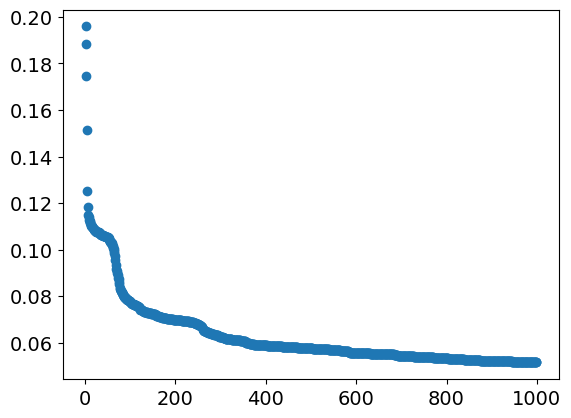

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


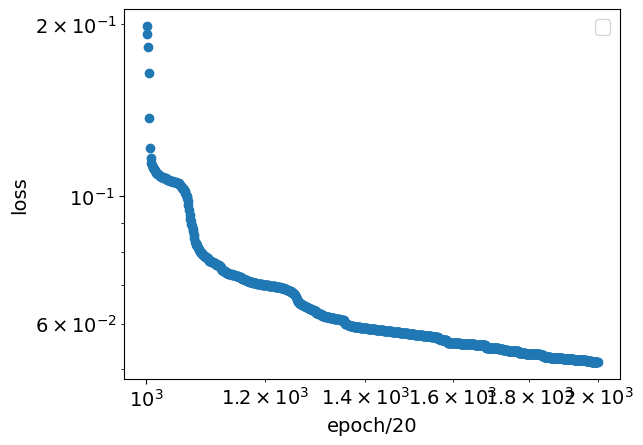

In [18]:
my_file = open("loss_function.txt", "r")
import numpy as np  
import matplotlib.pyplot as plt
# reading the file
data = my_file.read()
  
# replacing end of line('/n') with ' ' and
# splitting the text it further when '.' is seen.
data_into_list = data.replace('\n', ' ').split(" ")
print(data_into_list[:-1])
data=[]
for i in range(len(data_into_list[:-1])):
    data.append(float(data_into_list[i]))
print(len(data))
print(data)
x=np.arange(1,2001)
labels="noise:{:F}\nperturbation:{:F}".format(10**-3,10**-6)
plt.scatter(x[0:999],y=data[0:999],label=labels)
plt.show()
plt.scatter(x[1000:1999],y=data[1000:1999])
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("loss")
plt.xlabel("epoch/20")
plt.yscale("log")
plt.xscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("average jacobian.jpg")

plt.show()

In [ ]:
visualisation(input_image[0],0,"sample image with noise",True)
visualisation(batch_feature[0],0,"sample image without noise",True)